In [1]:
import sys
import os

this_path = os.getcwd()
path = '\\'.join(this_path.split('\\')[:-1])+'\\'
if path not in sys.path:
    sys.path.insert(0, path)
    print(path+" added to python path")
else:
    print(path+" already in python path")

%load_ext autoreload
%autoreload 2

C:\Users\mgutierrez\root\Projects\SDC\py\kaissandra\ added to python path


In [6]:
# Train/Test RNN
import h5py
import numpy as np
import pickle
from inputs import Data, load_separators, _build_bin_output, build_IO_from_var, build_DTA_from_var
from RNN import modelRNN
from features import get_init_end_dates, get_group_name

dateTest = ([                                                       '2018.03.09',
                '2018.03.12','2018.03.13','2018.03.14','2018.03.15','2018.03.16',
                '2018.03.19','2018.03.20','2018.03.21','2018.03.22','2018.03.23',
                '2018.03.26','2018.03.27','2018.03.28','2018.03.29','2018.03.30',
                '2018.04.02','2018.04.03','2018.04.04','2018.04.05','2018.04.06',
                '2018.04.09','2018.04.10','2018.04.11','2018.04.12','2018.04.13',
                '2018.04.16','2018.04.17','2018.04.18','2018.04.19','2018.04.20',
                '2018.04.23','2018.04.24','2018.04.25','2018.04.26','2018.04.27',
                '2018.04.30','2018.05.01','2018.05.02','2018.05.03','2018.05.04',
                '2018.05.07','2018.05.08','2018.05.09','2018.05.10','2018.05.11',
                '2018.05.14','2018.05.15','2018.05.16','2018.05.17','2018.05.18',
                '2018.05.21','2018.05.22','2018.05.23','2018.05.24','2018.05.25',
                '2018.05.28','2018.05.29','2018.05.30','2018.05.31','2018.06.01',
                '2018.06.04','2018.06.05','2018.06.06','2018.06.07','2018.06.08',
                '2018.06.11','2018.06.12','2018.06.13','2018.06.14','2018.06.15',
                '2018.06.18','2018.06.19','2018.06.20','2018.06.21','2018.06.22',
                '2018.06.25','2018.06.26','2018.06.27','2018.06.28','2018.06.29',
                '2018.07.02','2018.07.03','2018.07.04','2018.07.05','2018.07.06',
                '2018.07.09','2018.07.10','2018.07.11','2018.07.12','2018.07.13',
                '2018.07.30','2018.07.31','2018.08.01','2018.08.02','2018.08.03',
                '2018.08.06','2018.08.07','2018.08.08','2018.08.09','2018.08.10']+
               ['2018.08.13','2018.08.14','2018.08.15','2018.08.16','2018.08.17',
                '2018.08.20','2018.08.21','2018.08.22','2018.08.23','2018.08.24',
                '2018.08.27','2018.08.28','2018.08.29','2018.08.30','2018.08.31',
                '2018.09.03','2018.09.04','2018.09.05','2018.09.06','2018.09.07',
                '2018.09.10','2018.09.11','2018.09.12','2018.09.13','2018.09.14',
                '2018.09.17','2018.09.18','2018.09.19','2018.09.20','2018.09.21',
                '2018.09.24','2018.09.25','2018.09.26','2018.09.27']+['2018.09.28',
                '2018.10.01','2018.10.02','2018.10.03','2018.10.04','2018.10.05',
                '2018.10.08','2018.10.09','2018.10.10','2018.10.11','2018.10.12',
                '2018.10.15','2018.10.16','2018.10.17','2018.10.18','2018.10.19',
                '2018.10.22','2018.10.23','2018.10.24','2018.10.25','2018.10.26',
                '2018.10.29','2018.10.30','2018.10.31','2018.11.01','2018.11.02',
                '2018.11.05','2018.11.06','2018.11.07','2018.11.08','2018.11.09'])

data=Data(movingWindow=100,
          nEventsPerStat=1000,
          lB=1300, 
          dateTest=dateTest,
          assets=[1,2,3,4,7,8,10,11,12,13,14,15,16,17,19,27,28,29,30,31,32],
          channels=[0],
          max_var=10,
          feature_keys_manual=[],
          feature_keys_tsfresh=[],#[i for i in range(37,48)]+[49,50]+[i for i in range(52,68)],
          var_feat_keys=[i for i in range(68,93)])

model=modelRNN(data,
               size_hidden_layer=100,
               L=3,
               size_output_layer=5,
               keep_prob_dropout=1,
               miniBatchSize=32,
               outputGain=.6,
               commonY=3,
               lR0=0.0001,
               num_epochs=20)

tOt = 'tr' # tr->train te->test
if tOt == 'tr':
    calculate_roi = False
else:
    calculate_roi = True
if_build_IO = False
from_stats_file = False

IDweights = '000400'
IDresults = '100400'
IO_results_name = IDresults
hdf5_directory = 'D:/SDC/py/HDF5/'
feats_var_directory = hdf5_directory+'feats_var/'
IO_directory = '../RNN/IO/'
if tOt=='tr':
    filename_IO = IO_directory+'IO_'+IDweights+'.hdf5'
else:
    filename_IO = IO_directory+'IO_'+IO_results_name+'.hdf5'
separators_directory = hdf5_directory+'separators/'

# if IO structures have to be built 
if if_build_IO:
    # init dictionary containing IO structures
    IO = {}
    # open IO file for writting
    f_IO = h5py.File(filename_IO,'w')
    # init IO data sets
    X = f_IO.create_dataset('X',
                            (0, model.seq_len, model.nFeatures), 
                            maxshape=(None,model.seq_len, model.nFeatures), 
                            dtype=float)
    Y = f_IO.create_dataset('Y',
                            (0,model.seq_len,model.commonY+model.size_output_layer),
                            maxshape=(None,model.seq_len,model.commonY+
                            model.size_output_layer),
                            dtype=float)
    if calculate_roi:
        D = f_IO.create_dataset('D', (0,2),
                                    maxshape=(None,2),dtype='S19')
        B = f_IO.create_dataset('B', (0,2),
                                    maxshape=(None,2),dtype=float)
        A = f_IO.create_dataset('A', (0,2),
                                    maxshape=(None,2),dtype=float)
        IO['D'] = D
        IO['B'] = B
        IO['A'] = A
    # attributes to track asset-IO belonging
    ass_IO_ass = np.zeros((len(data.assets))).astype(int)
    # structure that tracks the number of samples per level
    totalSampsPerLevel = np.zeros((model.size_output_layer))
    # save IO structures in dictionary
    IO['X'] = X
    IO['Y'] = Y
    IO['pointer'] = 0
    
for ass_idx, ass in enumerate(data.assets):
    thisAsset = data.AllAssets[str(ass)]
    print(str(ass)+" "+thisAsset)
    #thisAsset = 'EURUSD'
    # load separators
    separators = load_separators(data, 
                                 thisAsset, 
                                 separators_directory, 
                                 tOt='tr', 
                                 from_txt=1)
    aloc = 2**20
    # index asset
    #ass_idx = 0

    filename_features = (feats_var_directory+thisAsset+'_feats_var_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_features = h5py.File(filename_features,'r')
    filename_returns = (feats_var_directory+thisAsset+'_rets_var_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_returns = h5py.File(filename_returns,'r')
    filename_symbols = (feats_var_directory+thisAsset+'_symbols_mW'+str(data.movingWindow)+'_nE'+
                                str(data.nEventsPerStat)+'.hdf5')
    file_symbols = h5py.File(filename_symbols,'r')
    filename_stats = (feats_var_directory+thisAsset+'_stats_mW'+str(data.movingWindow)+'_nE'+
                                    str(data.nEventsPerStat)+'.p')
    # init or load total stats
    if not from_stats_file:
        stats = {}
        # load stats in
        stats["means_in"] = file_features[thisAsset].attrs.get("means_in")
        stats["stds_in"] = file_features[thisAsset].attrs.get("stds_in")
        stats["m_in"] = file_features[thisAsset].attrs.get("m_in")
        # load stats out
        stats["means_out"] = file_returns[thisAsset].attrs.get("means_out")
        stats["stds_out"] = file_returns[thisAsset].attrs.get("stds_out")
        stats["m_out"] = file_returns[thisAsset].attrs.get("m_out")
    elif from_stats_file:
        stats = pickle.load( open( filename_stats, "rb" ))
    print(stats)

    nExS = data.nEventsPerStat
    mW = data.movingWindow
    if if_build_IO:
        for s in range(0,len(separators)-1,2):#
            print("\ts {0:d} of {1:d}".format(int(s/2),int(len(separators)/2-1))+
                  ". From "+separators.DateTime.iloc[s]+" to "+
                  separators.DateTime.iloc[s+1])

            # number of events within this separator chunk
            nE = separators.index[s+1]-separators.index[s]+1
            # get first day after separator
            day_s = separators.DateTime.iloc[s][0:10]
            # check if number of events is not enough to build two features and one return
            if nE-nExS>=2*nExS:
                if (tOt == 'tr' and (day_s not in data.dateTest and day_s<=data.dateTest[-1])) or \
                    (tOt == 'te' and (day_s in data.dateTest and day_s<=data.dateTest[-1])):
                    # init and end dates
                    init_date, end_date = get_init_end_dates(separators, s)
                    #print("init_date")
                    #print(init_date)
                    #print("end_date")
                    #print(end_date)
                    # get group name
                    group_name = get_group_name(thisAsset, init_date, end_date)
                    #print("group_name")
                    #print(group_name)
                    # load features
                    if group_name in file_features:
                        features = file_features[group_name]["features"]
                    else:
                        raise ValueError(group_name+" not in "+filename_features)
                    #print("features")
                    #print(features)
                    # load returns
                    if group_name in file_returns:
                        returns = file_returns[group_name]["returns"]
                    else:
                        raise ValueError(group_name+" not in "+filename_features)
                    #print(returns)
                    # load Symbols if calculate_roi is true
                    #TODO: Implement Symbol loading for test
                    if calculate_roi:
                        DT = file_symbols[group_name]["DT"]
                        B = file_symbols[group_name]["B"]
                        A = file_symbols[group_name]["A"]
                        # build dict w. symbols
                        symbols = {'DT':DT,
                                  'B':B,
                                  'A':A}
                    else:
                        symbols = {}
                    # build IO
                    IO, totalSampsPerLevel = build_IO_from_var_notebook(data, model, stats, IO, totalSampsPerLevel, 
                                                                        features, returns, symbols, calculate_roi)
                    print(totalSampsPerLevel)
                else:
                    print("\tNot in the set. Skipped.")

            else:
                print("\ts {0:d} of {1:d}. Not enough entries. Skipped.".format(
                    int(s/2),int(len(separators)/2-1)))
        # end of for s in range(0,len(separators)-1,2):
    if if_build_IO:
        ass_IO_ass[ass_idx] = IO['pointer']
        #print("\tTime for "+thisAsset+":"+str(np.floor(time.time()-tic))+"s"+
        #          ". Total time:"+str(np.floor(time.time()-ticTotal))+"s")
# end of for ass_idx, ass in enumerate(data.assets):
if if_build_IO:
    print("Samples to RNN: "+str(max(ass_IO_ass))+".\nPercent per level:"+
            str(totalSampsPerLevel/max(ass_IO_ass)))
    f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
    
    
    if calculate_roi:
        print("Building DTA...")
        DTA = build_DTA_from_var(data, IO['D'], IO['B'], IO['A'], ass_IO_ass)
        pickle.dump( DTA, open( "../RNN/IO/DTA"+"_"+IO_results_name+".p", "wb" ))
        f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
        
    f_IO.close()
else:
    if calculate_roi:
        DTA = pickle.load( open( "../RNN/IO/DTA"+"_"+IO_results_name+".p", "rb" ))
    # get ass_IO_ass from disk
    f_IO = h5py.File(filename_IO,'r')
    ass_IO_ass = f_IO.attrs.get("ass_IO_ass")
    f_IO.close()
m_t = max(ass_IO_ass)
print("DONE")

1 AUDCAD
{'means_in': array([[-4.36942530e-07, -4.47432327e-07, -4.37541144e-07,
        -4.21726903e-07, -2.50684735e-07, -1.27332027e-08,
         1.93838145e-06,  4.45454320e-06, -6.33446959e+01,
         7.77982540e+00,  5.31584223e-04, -5.31164977e-04,
         5.96836233e-04, -5.85379787e-04,  5.58178248e-01,
         5.00040691e-04, -5.01337145e-04,  1.29525496e+01,
         2.61798703e-03,  2.31730762e-02,  2.48865723e-02,
         6.42509688e-02,  9.67864073e-02,  2.16410337e-01,
         3.83013997e-01]]), 'means_out': array([-2.95589297e-08, -7.53936874e-08, -2.17893512e-07, -4.45835679e-07]), 'm_out': 868773, 'stds_out': array([0.00016564, 0.00022689, 0.00033817, 0.0004634 ]), 'stds_in': array([[4.63388284e-04, 4.34756482e-04, 3.39125208e-04, 2.69818604e-04,
        1.35063097e-04, 1.01298943e-04, 8.97005624e-05, 1.11987161e-04,
        3.96523083e+00, 2.27026236e+00, 4.30828392e-04, 4.35330111e-04,
        3.37656915e-04, 3.05043884e-04, 2.53610161e-01, 4.41937573e-04,
   

In [8]:
m_t

733966

In [8]:
# Train
import tensorflow as tf
# reset graph
alloc = 2**20
tf.reset_default_graph()
# start session
with tf.Session() as sess:    
    model.train(sess, int(np.ceil(m_t/aloc)), ID=IDweights, IDIO=IDweights, 
                data_format='hdf5', filename_IO=filename_IO, aloc=alloc)

ID = 000400
INFO:tensorflow:Restoring parameters from ../RNN/weights/000400/000005/000005
Parameters loaded. Epoch 5
Training from epoch 6 till 25
Time training Chunck 0 of 14: 383 s
Time training Chunck 1 of 14: 389 s
Time training Chunck 2 of 14: 402 s
Time training Chunck 3 of 14: 401 s
Time training Chunck 4 of 14: 404 s
Time training Chunck 5 of 14: 419 s
Time training Chunck 6 of 14: 402 s
Time training Chunck 7 of 14: 401 s
Time training Chunck 8 of 14: 417 s
Time training Chunck 9 of 14: 420 s
Time training Chunck 10 of 14: 414 s
Time training Chunck 11 of 14: 408 s
Time training Chunck 12 of 14: 391 s
Time training Chunck 13 of 14: 405 s
Time training Chunck 14 of 14: 359 s
Cost after epoch 6: 0.505045. Av cost 4.277871
13:37:19 Total time training: 100.38m
INFO:tensorflow:../RNN/weights/000400/000006/000006 is not in all_model_checkpoint_paths. Manually adding it.
Parameters saved
Time training Chunck 0 of 14: 398 s
Time training Chunck 1 of 14: 403 s
Time training Chunck 2 o

KeyboardInterrupt: 

In [ ]:
# Test
import tensorflow as tf

alloc = 200000
save_journal = False
startFrom = -1
endAt = -1
# reset graph
tf.reset_default_graph()
# start session
with tf.Session() as sess:
    # run test RNN
    print("IDresults: "+IDresults)
    # TEMP: GRE calculation not implemented in test2 yet. Use old test
    if save_journal:
        model.test(sess, data, IDresults, IDweights, 
                    alloc, 'test', startFrom=startFrom,
                    IDIO=IO_results_name, data_format='hdf5', DTA=DTA, 
                    save_journal=save_journal, endAt=endAt)
    else:
        model.test2(sess, data, IDresults, IDweights, 
                    alloc, 'test', startFrom=startFrom,
                    IDIO=IO_results_name, data_format='hdf5', DTA=DTA, 
                    save_journal=save_journal, endAt=endAt, from_var=True)
print("DONE")

In [1]:
# Function Build IO from var
def build_IO_from_var_notebook(data, model, stats, IO, totalSampsPerLevel, features, returns, symbols, calculate_roi):
    # total number of possible channels
    nExS = data.nEventsPerStat
    mW = data.movingWindow
    nChannels = int(nExS/mW)
    # sequence length
    seq_len = model.seq_len#int((data.lB-data.nEventsPerStat)/data.movingWindow)
    # samples allocation per batch
    aloc = 2**20
    # extract means and stats
    means_in = stats['means_in']
    stds_in = stats['stds_in']
    #m_in = stats['m_in']
    stds_out = stats['stds_out']
    #m_out = stats['m_out']
    #print("m_in")
    #print(m_in)
    #print("m_out")
    #print(m_out)
    # add dateTimes, bids and asks if are included in file
    if calculate_roi:
        dts = symbols['DT']
        bids = symbols['B']
        asks = symbols['A']

        D = IO['D']
        B = IO['B']
        A = IO['A']

    # extract IO structures
    X = IO['X']
    Y = IO['Y']
    #I = IO['I']
    pointer = IO['pointer']

    feats_var_normed = np.minimum(np.maximum((features-means_in)/\
                         stds_in,-data.max_var),data.max_var)
    # get some scalars
    nSamps = feats_var_normed.shape[0]
    print("features.shape")
    print(features.shape)
    print("nSamps")
    print(nSamps)
    samp_remaining = nSamps-2*nChannels-seq_len+1
    print("samp_remaining")
    print(samp_remaining)
    print("returns.shape")
    print(returns.shape)
    chunks = int(np.ceil(samp_remaining/aloc))
    # init counter of samps processed
    offset = 0
    # loop over chunks
    for i in range(chunks):
        # this batch length
        batch = np.min([samp_remaining, aloc])
        # create support numpy vectors to speed up iterations
        v_support = feats_var_normed[offset:offset+batch+seq_len, :]
        # get init and end indexes for returns
        init_idx_rets = nChannels+offset+seq_len-1
        print("init_idx_rets")
        print(init_idx_rets)
        end_idx_rets = nChannels+offset+batch+seq_len-1#+2*seq_len-1
        print("end_idx_rets")
        print(end_idx_rets)
        r_support = returns[init_idx_rets:end_idx_rets, data.lookAheadIndex]
        print("r_support.shape")
        print(r_support.shape)
        assert(r_support.shape[0]==end_idx_rets-init_idx_rets)
        # we only take here the entry time index, and later at DTA building the 
        # exit time index is derived from the entry time and the number of events to
        # look ahead
        if calculate_roi:
            dt_support = dts[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
            b_support = bids[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
            a_support = asks[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        # update remaining samps to proceed
        samp_remaining = samp_remaining-batch
        # init formatted input and output
        X_i = np.zeros((batch, seq_len, features.shape[1]))
        # real-valued output
        O_i = np.zeros((batch, seq_len, 1))    
        if calculate_roi:
            # last dimension is to incorporate in and out symbols
            D_i = np.chararray((batch, 2),itemsize=19)
            B_i = np.zeros((batch, 2))
            A_i = np.zeros((batch, 2))

        for nI in range(batch):
            # get input
            v_s_s = v_support[nI:nI+seq_len, :]
            X_i[nI,:,:] = v_s_s[::-1,:]#v_support[nI:nI+seq_len, :]            
            # due to substraction of features for variation, output gets the 
            # feature one entry later
            O_i[nI,:,0] = r_support[nI]
            if calculate_roi:
                D_i[nI,:] = dt_support[nI,:]
                B_i[nI,:] = b_support[nI,:]
                A_i[nI,:] = a_support[nI,:]

        # normalize output
        O_i = O_i/stds_out[data.lookAheadIndex]
        # update counters
        offset = offset+batch
        # get decimal and binary outputs
        Y_i, y_dec = _build_bin_output(model, O_i, batch)
        # get samples per level
        for l in range(model.size_output_layer):
            totalSampsPerLevel[l] = totalSampsPerLevel[l]+np.sum(y_dec[:,-1,0]==l)
        # resize IO structures
        X.resize((pointer+batch, seq_len,features.shape[1]))
        Y.resize((pointer+batch, seq_len,model.commonY+model.size_output_layer))
        # update IO structures
        X[pointer:pointer+batch,:,:] = X_i
        Y[pointer:pointer+batch,:,:] = Y_i
        if calculate_roi:
            # resize
            D.resize((pointer+batch, 2))
            B.resize((pointer+batch, 2))
            A.resize((pointer+batch, 2))
            # update
            D[pointer:pointer+batch,:] = D_i
            B[pointer:pointer+batch,:] = B_i
            A[pointer:pointer+batch,:] = A_i
    #        save_as_matfile('X_h_n_'+str(int(s/2)),'X_h_n'+str(int(s/2)),X_i)
    #        save_as_matfile('O_h_n_'+str(int(s/2)),'O_h_n'+str(int(s/2)),O_i)

        # uodate pointer
        pointer += batch
    # end of for i in range(chunks):
    # update dictionary
    IO['X'] = X
    IO['Y'] = Y
    IO['pointer'] = pointer
    if calculate_roi:
        IO['D'] = D
        IO['B'] = B
        IO['A'] = A
    
    return IO, totalSampsPerLevel
    

In [4]:
# Snippet Build IO from var

# total number of possible channels
nChannels = int(nExS/mW)
# sequence length
seq_len = model.seq_len#int((data.lB-data.nEventsPerStat)/data.movingWindow)
# samples allocation per batch
aloc = 2**20
# extract means and stats
means_in = stats['means_in']
stds_in = stats['stds_in']
m_in = stats['m_in']
stds_out = stats['stds_out']
m_out = stats['m_out']
#print("m_in")
#print(m_in)
#print("m_out")
#print(m_out)
# add dateTimes, bids and asks if are included in file
all_info = 0
if calculate_roi:
    all_info = 1
    dts = symbols['DT']
    bids = symbols['B']
    asks = symbols['A']
        
    D = IO['D']
    B = IO['B']
    A = IO['A']

# extract IO structures
X = IO['X']
Y = IO['Y']
#I = IO['I']
pointer = IO['pointer']

feats_var_normed = np.minimum(np.maximum((features-means_in)/\
                     stds_in,-data.max_var),data.max_var)
# get some scalars
nSamps = feats_var_normed.shape[0]
samp_remaining = nSamps-nChannels-seq_len-1
print("samp_remaining")
print(samp_remaining)
chunks = int(np.ceil(samp_remaining/aloc))
# init counter of samps processed
offset = 0
# loop over chunks
for i in range(chunks):
    # this batch length
    batch = np.min([samp_remaining,aloc])
    print("batch")
    print(batch)
    # create support numpy vectors to speed up iterations
    v_support = feats_var_normed[offset:offset+batch+seq_len, :]
    # get init and end indexes for returns
    init_idx_rets = nChannels+offset+seq_len-1
    end_idx_rets = nChannels+offset+batch+2*seq_len-1
    r_support = returns[init_idx_rets:end_idx_rets, data.lookAheadIndex]
    print("returns.shape")
    print(returns.shape)
    print("nChannels+offset+2")
    print(nChannels+offset+2)
    print("nChannels+offset+batch+seq_len+2")
    print(nChannels+offset+batch+seq_len+2)
    print("r_support.shape")
    print(r_support.shape)
    print("nChannels+offset+batch+seq_len+2-(nChannels+offset+2)")
    print(nChannels+offset+batch+seq_len+2-(nChannels+offset+2))
    print("returns[-1,data.lookAheadIndex]")
    print(returns[-1,data.lookAheadIndex])
    print("r_support[-1]")
    print(r_support[-1])
    # we only take here the entry time index, and later at DTA building the 
    # exit time index is derived from the entry time and the number of events to
    # look ahead
    if calculate_roi:
        dt_support = dts[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        b_support = bids[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
        a_support = asks[init_idx_rets:end_idx_rets, [0,data.lookAheadIndex+1]]
    # update remaining samps to proceed
    samp_remaining = samp_remaining-batch
    # init formatted input and output
    X_i = np.zeros((batch, seq_len, features.shape[1]))
    # real-valued output
    O_i = np.zeros((batch, seq_len, 1))    
    if calculate_roi:
        # last dimension is to incorporate in and out symbols
        D_i = np.chararray((batch, 2),itemsize=19)
        B_i = np.zeros((batch, 2))
        A_i = np.zeros((batch, 2))
    
    for nI in range(batch):
        # get input
        v_s_s = v_support[nI:nI+seq_len, :]
        X_i[nI,:,:] = v_s_s[::-1,:]#v_support[nI:nI+seq_len, :]            
        # due to substraction of features for variation, output gets the 
        # feature one entry later
        O_i[nI,:,0] = r_support[nI]
        if calculate_roi:
            D_i[nI,:] = dt_support[nI,:]
            B_i[nI,:] = b_support[nI,:]
            A_i[nI,:] = a_support[nI,:]
    
    # normalize output
    print("stds_out.shape")
    print(stds_out.shape)
    O_i = O_i/stds_out[data.lookAheadIndex]
    # update counters
    offset = offset+batch
    # get decimal and binary outputs
    Y_i, y_dec = _build_bin_output(model, O_i, batch)
    # get samples per level
    for l in range(model.size_output_layer):
        totalSampsPerLevel[l] = totalSampsPerLevel[l]+np.sum(y_dec[:,-1,0]==l)
    # resize IO structures
    X.resize((pointer+batch, seq_len,features.shape[1]))
    Y.resize((pointer+batch, seq_len,model.commonY+model.size_output_layer))
    # update IO structures
    X[pointer:pointer+batch,:,:] = X_i
    Y[pointer:pointer+batch,:,:] = Y_i
    if calculate_roi:
        # resize
        D.resize((pointer+batch, 2))
        B.resize((pointer+batch, 2))
        A.resize((pointer+batch, 2))
        # update
        D[pointer:pointer+batch,:] = D_i
        B[pointer:pointer+batch,:] = B_i
        A[pointer:pointer+batch,:] = A_i
#        save_as_matfile('X_h_n_'+str(int(s/2)),'X_h_n'+str(int(s/2)),X_i)
#        save_as_matfile('O_h_n_'+str(int(s/2)),'O_h_n'+str(int(s/2)),O_i)
        
    # uodate pointer
    pointer += batch
# end of for i in range(chunks):
# update dictionary
IO['X'] = X
IO['Y'] = Y
IO['pointer'] = pointer
if calculate_roi:
    IO['D'] = D
    IO['B'] = B
    IO['A'] = A
print("totalSampsPerLevel")
print(totalSampsPerLevel)

if if_build_IO:
    ass_IO_ass[ass_idx] = IO['pointer']
    #print("\tTime for "+thisAsset+":"+str(np.floor(time.time()-tic))+"s"+
    #          ". Total time:"+str(np.floor(time.time()-ticTotal))+"s")
# end of assets loop?
if if_build_IO:
    f_IO.attrs.create('ass_IO_ass', ass_IO_ass, dtype=int)
    f_IO.close()
else:
    # get ass_IO_ass from disk
    f_IO = h5py.File(filename_IO,'r')
    ass_IO_ass = f_IO.attrs.get("ass_IO_ass")
    f_IO.close()
m_t = IO['pointer']
print("m_t")
print(m_t)
print("IO['pointer']")
print(IO['pointer'])

m_in
42343
m_out
42333
samp_remaining
42319
batch
42319
returns.shape
(42333, 4)
nChannels+offset+2
12
nChannels+offset+batch+seq_len+2
42334
r_support.shape
(42321,)
nChannels+offset+batch+seq_len+2-(nChannels+offset+2)
42322
returns[-1,data.lookAheadIndex]
9.999999999998899e-05
r_support[-1]
9.999999999998899e-05
stds_out.shape
(4,)
totalSampsPerLevel
[  320.  6215. 29138.  6239.   407.]
m_t
42319
IO['pointer']
42319


In [5]:
f_IO.close()

In [6]:
O_i.shape

(42319, 3, 1)

In [19]:
# Test


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from config import configuration
# define config structure
entries = {'config_name':'C0400',
          
          'movingWindow':100,
          'nEventsPerStat':1000,
          'lB':1300,
          'feature_keys_manual':[],
          'feature_keys_tsfresh':[],
           'var_feat_keys':[i for i in range(68,93)],
          
          'if_build_IO':False,
          'from_stats_file':False,
          'IDweights':'000400',
          'inverse_load':True,
          
          'IDresults':'100400',
          'startFrom':-1,
          'endAt':-1,
          'save_journal':False}

config = configuration(entries)

WARNING! Arguments not taken into consideration
Config file ../config/C0400.config exists. Loaded from disk


In [ ]:
build_and_test(config)

In [16]:
from config import modify_config

modify_config(config['config_name'],'if_build_IO',False)
config = retrieve_config(config['config_name'])

[autoreload of inputs failed: Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 384, in superreload
    update_generic(old_obj, new_obj)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 323, in update_generic
    update(a, b)
  File "C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\IPython\extensions\autoreload.py", line 278, in update_class
    if old_obj == new_obj:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]


Config file ../config/C0400.config saved
Config file ../config/C0400.config loaded from disk


In [15]:
build_and_train(config)

1 AUDCAD
2 EURAUD
3 EURCAD
4 EURCHF
7 EURGBP
8 EURNZD
10 EURUSD
11 GBPAUD
12 GBPCAD
13 GBPCHF
14 GBPUSD
15 GOLD
16 USDCAD
17 USDCHF
19 USDJPY
27 CADJPY
28 EURJPY
29 AUDJPY
30 CHFJPY
31 GBPJPY
32 NZDUSD
ID = 000400
INFO:tensorflow:Restoring parameters from ../RNN/weights/000400/000007/000007
Parameters loaded. Epoch 7
Training from epoch 8 till 27
Time training Chunck 0 of 14: 367 s
Time training Chunck 1 of 14: 366 s
Time training Chunck 2 of 14: 375 s
Time training Chunck 3 of 14: 385 s
Time training Chunck 4 of 14: 395 s
Time training Chunck 5 of 14: 387 s
Time training Chunck 6 of 14: 391 s
Time training Chunck 7 of 14: 392 s
Time training Chunck 8 of 14: 388 s
Time training Chunck 9 of 14: 397 s
Time training Chunck 10 of 14: 421 s
Time training Chunck 11 of 14: 398 s
Time training Chunck 12 of 14: 391 s
Time training Chunck 13 of 14: 410 s
Time training Chunck 14 of 14: 360 s
Cost after epoch 8: 0.543258. Av cost 4.276548
17:49:55 Total time training: 97.15m
INFO:tensorflow:../RNN

KeyboardInterrupt: 

In [26]:
import pandas as pd
positions = pd.read_csv('../../RNN/results/100318R20/positions/P_E29TI0MC0.5MD0.75.csv',sep='\t')
#positions = pd.read_csv('../../RNN/results/100318INVO/positions/P_E15TI1MC0.7MD0.7.csv',sep='\t')
positions

,Asset,Di,Ti,Do,To,GROI,ROI,spread,ext
0,AUDCAD,2018.03.19,00:57:38,2018.03.19,01:36:09,0.0337,0.0079,0.0257,0
1,AUDCAD,2018.03.20,02:51:09,2018.03.20,03:11:27,0.0407,0.0179,0.0228,0
2,AUDCAD,2018.03.22,00:59:23,2018.03.22,01:30:28,0.0929,0.0679,0.0250,0
3,AUDCAD,2018.03.22,02:30:14,2018.03.22,02:42:32,-0.1387,-0.1636,0.0249,0
4,AUDCAD,2018.03.23,01:00:56,2018.03.23,01:13:22,-0.0392,-0.0643,0.0251,0
5,AUDCAD,2018.03.26,00:13:48,2018.03.26,01:01:16,0.0413,0.0111,0.0302,0
6,AUDCAD,2018.03.28,23:43:57,2018.03.29,01:00:00,0.0808,0.0262,0.0546,3
7,AUDCAD,2018.03.30,02:16:01,2018.03.30,02:26:22,0.0718,-0.0071,0.0789,0
8,AUDCAD,2018.03.30,23:53:50,2018.04.02,01:53:14,0.0505,0.0212,0.0293,1
9,AUDCAD,2018.04.03,00:14:29,2018.04.03,00:38:47,0.0253,-0.0162,0.0415,1


In [90]:
positions = pd.read_csv('../../RNN/results/100318R20/positions/P_E29TI0MC0.5MD0.75.csv',sep='\t')
pos_under_2p = positions['spread']<0.01
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(positions[pos_under_2p]['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
print(positions[pos_under_2p].shape[0])
print(per_under_2p)
print(tgsr)
print(gsr)
print(tsr)
print(sr)
print(positions[pos_under_2p]['ROI'].sum())
print(positions['GROI'].sum()-0.02*positions['GROI'].shape[0])
print(positions['Asset'][pos_under_2p].unique())

34
1.9871420222092344
82.46639392168322
61.76470588235294
37.697253068381066
52.94117647058823
0.06059999999999997
25.48230000000001
['EURCAD' 'EURCHF' 'EURGBP' 'EURUSD' 'GBPUSD' 'USDCAD' 'USDCHF' 'USDJPY'
 'EURJPY' 'GBPJPY']


In [87]:
positions = pd.read_csv('../../RNN/results/100318INVO/positions/P_E15TI1MC0.7MD0.7.csv',sep='\t')
pos_under_2p = positions['spread']<0.05
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(positions[pos_under_2p]['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
print("positions[pos_under_2p].shape[0]")
print(positions[pos_under_2p].shape[0])
print("per_under_2p")
print(per_under_2p)
print("tgsr")
print(tgsr)
print("gsr")
print(gsr)
print("tsr")
print(tsr)
print("sr")
print(sr)
print("positions[pos_under_2p]['ROI'].sum()")
print(positions[pos_under_2p]['ROI'].sum())
print("positions['GROI'].sum()-0.02*positions['GROI'].shape[0]")
print(positions['GROI'].sum()-0.02*positions['GROI'].shape[0])

positions[pos_under_2p].shape[0]
596
per_under_2p
61.003070624360284
tgsr
80.14329580348004
gsr
77.18120805369128
tsr
46.46878198567042
sr
59.899328859060404
positions[pos_under_2p]['ROI'].sum()
5.5505
positions['GROI'].sum()-0.02*positions['GROI'].shape[0]
20.204500000000003


In [ ]:
# edit config without saving for test purposes
from kaissandra.testRNN import test_RNN
from kaissandra.config import *
config=retrieve_config('C0326INVO')
config['IDresults']='100326R20'
config['save_journal']=True
config['startFrom']=51
config['endAt']=51
resolution = 20
config['resolution'] = resolution
config['thresholds_mc'] = [.5+i/resolution for i in range(int(resolution/2))]
config['thresholds_md'] = [.5+i/resolution for i in range(int(resolution/2))]

test_RNN(config)

Config file ../../config/C0326INVO.config loaded from disk
IDresults: 100326R20
INFO:tensorflow:Restoring parameters from ../../RNN/weights/000326INVO/000051/000051
Parameters loaded. Epoch 51
Epoch 51 of 51. Getting output...


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [02:43<00:00,  4.35s/it]


Getting results
Epoch 51, J_train = 6.433153344918188, J_test = 1.5601625953401839


0it [00:00, ?it/s]
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 1.5601625953401839, J_train = 6.433153344918188, Accuracy=0.5638812944909571
RD = 360956 NZ = 693630 NZA = 1296656 pNZ = 40.186% pNZA = 75.123% AD = 52.04% ADA = 27.84% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.55
RD = 85590 NZ = 153477 NZA = 281248 pNZ = 8.892% pNZA = 16.294% AD = 55.77% ADA = 30.43% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 64240/64240 [00:16<00:00, 3838.11it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.6
RD = 21226 NZ = 34289 NZA = 64241 pNZ = 1.987% pNZA = 3.722% AD = 61.90% ADA = 33.04% NO = 11338 GSP = 58.42% NSP = 43.40%
SI2 = -975.90 SI = -1314.90 eGROI = 113.09% eROI = -157.70% eROI2 = -113.67% eROI3 = -227.05% mSpread = 0.0239%


100%|██████████████████████████████████████████████████████████████████████████| 23894/23894 [00:06<00:00, 3424.20it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.65
RD = 8611 NZ = 12566 NZA = 23895 pNZ = 0.728% pNZA = 1.384% AD = 68.53% ADA = 36.04% NO = 5023 GSP = 64.09% NSP = 43.86%
SI2 = -203.65 SI = -559.65 eGROI = 77.97% eROI = -66.99% eROI2 = -22.49% eROI3 = -72.72% mSpread = 0.0289%


100%|██████████████████████████████████████████████████████████████████████████| 10515/10515 [00:03<00:00, 3370.21it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.7
RD = 4143 NZ = 5591 NZA = 10516 pNZ = 0.324% pNZA = 0.609% AD = 74.10% ADA = 39.40% NO = 2833 GSP = 70.14% NSP = 44.76%
SI2 = 22.85 SI = -290.15 eGROI = 65.83% eROI = -29.85% eROI2 = 9.17% eROI3 = -19.16% mSpread = 0.0338%


100%|████████████████████████████████████████████████████████████████████████████| 4606/4606 [00:01<00:00, 3260.63it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.75
RD = 2022 NZ = 2529 NZA = 4607 pNZ = 0.147% pNZA = 0.267% AD = 79.95% ADA = 43.89% NO = 1662 GSP = 74.67% NSP = 47.23%
SI2 = 110.90 SI = -129.10 eGROI = 52.58% eROI = -9.38% eROI2 = 19.34% eROI3 = 2.72% mSpread = 0.0373%


100%|████████████████████████████████████████████████████████████████████████████| 1976/1976 [00:00<00:00, 2662.00it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.8
RD = 990 NZ = 1144 NZA = 1977 pNZ = 0.066% pNZA = 0.115% AD = 86.54% ADA = 50.08% NO = 981 GSP = 82.67% NSP = 54.03%
SI2 = 138.45 SI = -9.55 eGROI = 44.91% eROI = 5.73% eROI2 = 25.29% eROI3 = 15.48% mSpread = 0.0399%


100%|██████████████████████████████████████████████████████████████████████████████| 868/868 [00:00<00:00, 1921.83it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.85
RD = 490 NZ = 546 NZA = 869 pNZ = 0.032% pNZA = 0.050% AD = 89.74% ADA = 56.39% NO = 559 GSP = 85.87% NSP = 56.17%
SI2 = 102.55 SI = 6.55 eGROI = 27.40% eROI = 2.91% eROI2 = 16.22% eROI3 = 10.63% mSpread = 0.0438%


100%|██████████████████████████████████████████████████████████████████████████████| 305/305 [00:00<00:00, 1943.29it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.9
RD = 176 NZ = 193 NZA = 306 pNZ = 0.011% pNZA = 0.018% AD = 91.19% ADA = 57.52% NO = 252 GSP = 83.73% NSP = 55.16%
SI2 = 44.40 SI = 0.40 eGROI = 12.77% eROI = 0.52% eROI2 = 7.73% eROI3 = 5.21% mSpread = 0.0486%


100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 1138.01it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.5. Threshold MD = 0.95
RD = 25 NZ = 25 NZA = 41 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 60.98% NO = 41 GSP = 90.24% NSP = 51.22%
SI2 = 7.45 SI = -1.55 eGROI = 2.43% eROI = 0.16% eROI2 = 1.61% eROI3 = 1.20% mSpread = 0.0556%



0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.5
RD = 255717 NZ = 489114 NZA = 860562 pNZ = 28.337% pNZA = 49.857% AD = 52.28% ADA = 29.72% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.55
RD = 67749 NZ = 120752 NZA = 208993 pNZ = 6.996% pNZA = 12.108% AD = 56.11% ADA = 32.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 47306/47306 [00:12<00:00, 3762.88it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.6
RD = 16841 NZ = 27070 NZA = 47307 pNZ = 1.568% pNZA = 2.741% AD = 62.21% ADA = 35.60% NO = 9455 GSP = 59.75% NSP = 45.00%
SI2 = -608.25 SI = -945.25 eGROI = 113.16% eROI = -116.26% eROI2 = -75.94% eROI3 = -170.49% mSpread = 0.0243%


100%|██████████████████████████████████████████████████████████████████████████| 17949/17949 [00:05<00:00, 3185.96it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.65
RD = 6894 NZ = 10036 NZA = 17950 pNZ = 0.581% pNZA = 1.040% AD = 68.69% ADA = 38.41% NO = 4142 GSP = 64.27% NSP = 44.45%
SI2 = -119.10 SI = -437.10 eGROI = 72.29% eROI = -50.22% eROI2 = -10.55% eROI3 = -51.97% mSpread = 0.0296%


100%|████████████████████████████████████████████████████████████████████████████| 8242/8242 [00:03<00:00, 2347.38it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.7
RD = 3407 NZ = 4610 NZA = 8243 pNZ = 0.267% pNZA = 0.478% AD = 73.90% ADA = 41.33% NO = 2335 GSP = 71.01% NSP = 46.12%
SI2 = 65.75 SI = -207.25 eGROI = 59.16% eROI = -21.76% eROI2 = 12.46% eROI3 = -10.89% mSpread = 0.0347%


100%|████████████████████████████████████████████████████████████████████████████| 3709/3709 [00:01<00:00, 2163.05it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.75
RD = 1699 NZ = 2133 NZA = 3710 pNZ = 0.124% pNZA = 0.215% AD = 79.65% ADA = 45.80% NO = 1391 GSP = 74.55% NSP = 48.38%
SI2 = 100.95 SI = -92.05 eGROI = 46.18% eROI = -6.79% eROI2 = 18.36% eROI3 = 4.45% mSpread = 0.0381%


100%|████████████████████████████████████████████████████████████████████████████| 1618/1618 [00:00<00:00, 2579.77it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.8
RD = 849 NZ = 983 NZA = 1619 pNZ = 0.057% pNZA = 0.094% AD = 86.37% ADA = 52.44% NO = 831 GSP = 82.79% NSP = 55.35%
SI2 = 124.95 SI = 2.95 eGROI = 39.62% eROI = 5.76% eROI2 = 23.00% eROI3 = 14.69% mSpread = 0.0407%


100%|██████████████████████████████████████████████████████████████████████████████| 746/746 [00:00<00:00, 1629.63it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.85
RD = 436 NZ = 488 NZA = 747 pNZ = 0.028% pNZA = 0.043% AD = 89.34% ADA = 58.37% NO = 488 GSP = 85.66% NSP = 57.17%
SI2 = 94.60 SI = 10.60 eGROI = 24.80% eROI = 2.99% eROI2 = 15.04% eROI3 = 10.16% mSpread = 0.0447%


100%|██████████████████████████████████████████████████████████████████████████████| 279/279 [00:00<00:00, 2398.11it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.9
RD = 164 NZ = 180 NZA = 280 pNZ = 0.010% pNZA = 0.016% AD = 91.11% ADA = 58.57% NO = 230 GSP = 83.48% NSP = 55.22%
SI2 = 39.50 SI = 0.50 eGROI = 11.94% eROI = 0.63% eROI2 = 7.34% eROI3 = 5.04% mSpread = 0.0492%


100%|████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 1558.02it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.55. Threshold MD = 0.95
RD = 25 NZ = 25 NZA = 41 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 60.98% NO = 41 GSP = 90.24% NSP = 51.22%
SI2 = 7.45 SI = -1.55 eGROI = 2.43% eROI = 0.16% eROI2 = 1.61% eROI3 = 1.20% mSpread = 0.0556%



0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.5
RD = 128161 NZ = 242308 NZA = 396234 pNZ = 14.038% pNZA = 22.956% AD = 52.89% ADA = 32.34% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 121572/121572 [00:32<00:00, 3754.88it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.55
RD = 42687 NZ = 75089 NZA = 121573 pNZ = 4.350% pNZA = 7.043% AD = 56.85% ADA = 35.11% NO = 17896 GSP = 57.78% NSP = 45.52%
SI2 = -1488.80 SI = -1696.80 eGROI = 107.65% eROI = -278.17% eROI2 = -250.27% eROI3 = -429.23% mSpread = 0.0216%


100%|██████████████████████████████████████████████████████████████████████████| 30324/30324 [00:09<00:00, 3256.82it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.6
RD = 11736 NZ = 18732 NZA = 30325 pNZ = 1.085% pNZA = 1.757% AD = 62.65% ADA = 38.70% NO = 6970 GSP = 61.03% NSP = 47.27%
SI2 = -305.50 SI = -538.50 eGROI = 102.24% eROI = -66.66% eROI2 = -37.16% eROI3 = -106.86% mSpread = 0.0242%


100%|██████████████████████████████████████████████████████████████████████████| 11830/11830 [00:03<00:00, 3376.52it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.65
RD = 4880 NZ = 7143 NZA = 11831 pNZ = 0.414% pNZA = 0.685% AD = 68.32% ADA = 41.25% NO = 3081 GSP = 65.53% NSP = 47.03%
SI2 = -9.55 SI = -245.55 eGROI = 63.28% eROI = -29.82% eROI2 = 1.66% eROI3 = -29.15% mSpread = 0.0302%


100%|████████████████████████████████████████████████████████████████████████████| 5726/5726 [00:01<00:00, 3115.67it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.7
RD = 2471 NZ = 3376 NZA = 5727 pNZ = 0.196% pNZA = 0.332% AD = 73.19% ADA = 43.15% NO = 1772 GSP = 71.90% NSP = 48.19%
SI2 = 82.40 SI = -120.60 eGROI = 50.50% eROI = -11.79% eROI2 = 15.06% eROI3 = -2.66% mSpread = 0.0352%


100%|████████████████████████████████████████████████████████████████████████████| 2721/2721 [00:01<00:00, 2399.43it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.75
RD = 1295 NZ = 1649 NZA = 2722 pNZ = 0.096% pNZA = 0.158% AD = 78.53% ADA = 47.58% NO = 1095 GSP = 74.89% NSP = 50.78%
SI2 = 97.75 SI = -46.25 eGROI = 39.30% eROI = -2.24% eROI2 = 17.40% eROI3 = 6.45% mSpread = 0.0379%


100%|████████████████████████████████████████████████████████████████████████████| 1226/1226 [00:00<00:00, 2400.83it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.8
RD = 666 NZ = 779 NZA = 1227 pNZ = 0.045% pNZA = 0.071% AD = 85.49% ADA = 54.28% NO = 673 GSP = 83.21% NSP = 58.25%
SI2 = 108.85 SI = 21.85 eGROI = 34.23% eROI = 6.93% eROI2 = 20.77% eROI3 = 14.04% mSpread = 0.0406%


100%|██████████████████████████████████████████████████████████████████████████████| 591/591 [00:00<00:00, 2043.27it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.85
RD = 364 NZ = 410 NZA = 592 pNZ = 0.024% pNZA = 0.034% AD = 88.78% ADA = 61.49% NO = 402 GSP = 86.82% NSP = 60.70%
SI2 = 88.90 SI = 22.90 eGROI = 22.11% eROI = 4.50% eROI2 = 14.07% eROI3 = 10.05% mSpread = 0.0438%


100%|██████████████████████████████████████████████████████████████████████████████| 242/242 [00:00<00:00, 1340.52it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.9
RD = 146 NZ = 162 NZA = 243 pNZ = 0.009% pNZA = 0.014% AD = 90.12% ADA = 60.08% NO = 202 GSP = 84.65% NSP = 56.93%
SI2 = 40.90 SI = 3.90 eGROI = 10.96% eROI = 1.03% eROI2 = 6.92% eROI3 = 4.90% mSpread = 0.0492%


100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 1396.51it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.6. Threshold MD = 0.95
RD = 25 NZ = 25 NZA = 40 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 62.50% NO = 40 GSP = 90.00% NSP = 52.50%
SI2 = 8.00 SI = -1.00 eGROI = 2.43% eROI = 0.17% eROI2 = 1.63% eROI3 = 1.23% mSpread = 0.0564%



100%|████████████████████████████████████████████████████████████████████████| 123144/123144 [00:29<00:00, 4217.21it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.5
RD = 43739 NZ = 81713 NZA = 123145 pNZ = 4.734% pNZA = 7.134% AD = 53.53% ADA = 35.52% NO = 9917 GSP = 57.04% NSP = 46.24%
SI2 = -706.35 SI = -868.35 eGROI = 72.24% eROI = -147.29% eROI2 = -126.10% eROI3 = -225.27% mSpread = 0.0221%


100%|██████████████████████████████████████████████████████████████████████████| 48794/48794 [00:11<00:00, 4236.91it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.55
RD = 18818 NZ = 32480 NZA = 48795 pNZ = 1.882% pNZA = 2.827% AD = 57.94% ADA = 38.57% NO = 8475 GSP = 58.89% NSP = 47.68%
SI2 = -456.25 SI = -620.25 eGROI = 83.48% eROI = -102.17% eROI2 = -86.02% eROI3 = -170.77% mSpread = 0.0219%


100%|██████████████████████████████████████████████████████████████████████████| 16143/16143 [00:04<00:00, 3691.71it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.6
RD = 6843 NZ = 10791 NZA = 16144 pNZ = 0.625% pNZA = 0.935% AD = 63.41% ADA = 42.39% NO = 4292 GSP = 62.37% NSP = 50.40%
SI2 = -67.60 SI = -197.60 eGROI = 73.20% eROI = -31.53% eROI2 = -12.64% eROI3 = -55.56% mSpread = 0.0244%


100%|████████████████████████████████████████████████████████████████████████████| 6593/6593 [00:01<00:00, 3831.68it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.65
RD = 2962 NZ = 4391 NZA = 6594 pNZ = 0.254% pNZA = 0.382% AD = 67.46% ADA = 44.92% NO = 2071 GSP = 67.07% NSP = 50.46%
SI2 = 48.95 SI = -94.05 eGROI = 46.87% eROI = -15.69% eROI2 = 5.45% eROI3 = -15.26% mSpread = 0.0302%


100%|████████████████████████████████████████████████████████████████████████████| 3185/3185 [00:00<00:00, 3751.57it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.7
RD = 1485 NZ = 2066 NZA = 3186 pNZ = 0.120% pNZA = 0.185% AD = 71.88% ADA = 46.61% NO = 1199 GSP = 72.89% NSP = 51.29%
SI2 = 75.55 SI = -44.45 eGROI = 36.44% eROI = -5.86% eROI2 = 12.46% eROI3 = 0.47% mSpread = 0.0353%


100%|████████████████████████████████████████████████████████████████████████████| 1602/1602 [00:00<00:00, 1754.80it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.75
RD = 812 NZ = 1061 NZA = 1603 pNZ = 0.061% pNZA = 0.093% AD = 76.53% ADA = 50.66% NO = 761 GSP = 75.69% NSP = 53.88%
SI2 = 81.45 SI = -8.55 eGROI = 29.39% eROI = 0.23% eROI2 = 14.17% eROI3 = 6.56% mSpread = 0.0383%


100%|██████████████████████████████████████████████████████████████████████████████| 824/824 [00:00<00:00, 2876.57it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.8
RD = 465 NZ = 561 NZA = 825 pNZ = 0.033% pNZA = 0.048% AD = 82.89% ADA = 56.36% NO = 489 GSP = 83.44% NSP = 60.94%
SI2 = 88.05 SI = 29.05 eGROI = 26.43% eROI = 6.29% eROI2 = 16.65% eROI3 = 11.76% mSpread = 0.0412%


100%|██████████████████████████████████████████████████████████████████████████████| 447/447 [00:00<00:00, 2752.04it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.85
RD = 279 NZ = 320 NZA = 448 pNZ = 0.019% pNZA = 0.026% AD = 87.19% ADA = 62.28% NO = 321 GSP = 85.05% NSP = 61.37%
SI2 = 70.45 SI = 20.45 eGROI = 18.67% eROI = 4.26% eROI2 = 12.25% eROI3 = 9.04% mSpread = 0.0449%


100%|██████████████████████████████████████████████████████████████████████████████| 192/192 [00:00<00:00, 2115.49it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.9
RD = 120 NZ = 135 NZA = 193 pNZ = 0.008% pNZA = 0.011% AD = 88.89% ADA = 62.18% NO = 161 GSP = 84.47% NSP = 57.14%
SI2 = 35.45 SI = 3.45 eGROI = 9.38% eROI = 0.89% eROI2 = 6.16% eROI3 = 4.55% mSpread = 0.0527%


100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 1313.99it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.65. Threshold MD = 0.95
RD = 24 NZ = 24 NZA = 38 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 63.16% NO = 38 GSP = 89.47% NSP = 52.63%
SI2 = 8.10 SI = -0.90 eGROI = 2.33% eROI = 0.14% eROI2 = 1.57% eROI3 = 1.19% mSpread = 0.0578%



100%|██████████████████████████████████████████████████████████████████████████| 32673/32673 [00:06<00:00, 5374.88it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.5
RD = 12878 NZ = 23313 NZA = 32674 pNZ = 1.351% pNZA = 1.893% AD = 55.24% ADA = 39.41% NO = 3945 GSP = 58.66% NSP = 48.77%
SI2 = -181.75 SI = -245.75 eGROI = 42.67% eROI = -46.33% eROI2 = -36.23% eROI3 = -75.68% mSpread = 0.0226%


100%|██████████████████████████████████████████████████████████████████████████| 16637/16637 [00:03<00:00, 4508.30it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.55
RD = 7035 NZ = 11944 NZA = 16638 pNZ = 0.692% pNZA = 0.964% AD = 58.90% ADA = 42.28% NO = 3312 GSP = 59.63% NSP = 49.58%
SI2 = -118.60 SI = -179.60 eGROI = 45.91% eROI = -29.74% eROI2 = -20.33% eROI3 = -53.45% mSpread = 0.0228%


100%|████████████████████████████████████████████████████████████████████████████| 7505/7505 [00:01<00:00, 4136.83it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.6
RD = 3413 NZ = 5429 NZA = 7506 pNZ = 0.315% pNZA = 0.435% AD = 62.87% ADA = 45.47% NO = 2189 GSP = 62.77% NSP = 52.03%
SI2 = 5.05 SI = -64.95 eGROI = 41.47% eROI = -12.57% eROI2 = -2.31% eROI3 = -24.20% mSpread = 0.0247%


100%|████████████████████████████████████████████████████████████████████████████| 3312/3312 [00:00<00:00, 3590.47it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.65
RD = 1597 NZ = 2412 NZA = 3313 pNZ = 0.140% pNZA = 0.192% AD = 66.21% ADA = 48.20% NO = 1213 GSP = 68.01% NSP = 53.83%
SI2 = 63.85 SI = -14.15 eGROI = 33.71% eROI = -1.26% eROI2 = 9.45% eROI3 = -2.68% mSpread = 0.0288%


100%|████████████████████████████████████████████████████████████████████████████| 1525/1525 [00:00<00:00, 3460.15it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.7
RD = 786 NZ = 1124 NZA = 1526 pNZ = 0.065% pNZA = 0.088% AD = 69.93% ADA = 51.51% NO = 670 GSP = 72.99% NSP = 56.12%
SI2 = 72.50 SI = 7.50 eGROI = 25.02% eROI = 2.38% eROI2 = 11.62% eROI3 = 4.92% mSpread = 0.0338%


100%|██████████████████████████████████████████████████████████████████████████████| 826/826 [00:00<00:00, 3148.95it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.75
RD = 451 NZ = 602 NZA = 827 pNZ = 0.035% pNZA = 0.048% AD = 74.92% ADA = 54.53% NO = 434 GSP = 77.65% NSP = 57.14%
SI2 = 61.30 SI = 9.30 eGROI = 18.99% eROI = 2.38% eROI2 = 10.31% eROI3 = 5.97% mSpread = 0.0383%


100%|██████████████████████████████████████████████████████████████████████████████| 508/508 [00:00<00:00, 2291.78it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.8
RD = 290 NZ = 363 NZA = 509 pNZ = 0.021% pNZA = 0.029% AD = 79.89% ADA = 56.97% NO = 305 GSP = 83.61% NSP = 60.00%
SI2 = 56.25 SI = 15.25 eGROI = 16.70% eROI = 3.53% eROI2 = 10.60% eROI3 = 7.55% mSpread = 0.0432%


100%|██████████████████████████████████████████████████████████████████████████████| 305/305 [00:00<00:00, 2312.19it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.85
RD = 190 NZ = 225 NZA = 306 pNZ = 0.013% pNZA = 0.018% AD = 84.44% ADA = 62.09% NO = 218 GSP = 85.78% NSP = 60.09%
SI2 = 51.10 SI = 11.10 eGROI = 12.98% eROI = 2.65% eROI2 = 8.62% eROI3 = 6.44% mSpread = 0.0474%


100%|██████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 2091.38it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.9
RD = 92 NZ = 104 NZA = 147 pNZ = 0.006% pNZA = 0.009% AD = 88.46% ADA = 62.59% NO = 119 GSP = 86.55% NSP = 57.98%
SI2 = 28.55 SI = 3.55 eGROI = 7.46% eROI = 1.01% eROI2 = 5.08% eROI3 = 3.89% mSpread = 0.0542%


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1589.22it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.7. Threshold MD = 0.95
RD = 21 NZ = 21 NZA = 32 pNZ = 0.001% pNZA = 0.002% AD = 100.00% ADA = 65.62% NO = 32 GSP = 90.62% NSP = 56.25%
SI2 = 8.40 SI = 0.40 eGROI = 2.20% eROI = 0.28% eROI2 = 1.56% eROI3 = 1.24% mSpread = 0.0601%



100%|████████████████████████████████████████████████████████████████████████████| 7644/7644 [00:01<00:00, 4591.40it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.5
RD = 3316 NZ = 5750 NZA = 7645 pNZ = 0.333% pNZA = 0.443% AD = 57.67% ADA = 43.37% NO = 1618 GSP = 58.84% NSP = 49.69%
SI2 = -47.90 SI = -85.90 eGROI = 19.18% eROI = -19.07% eROI2 = -13.18% eROI3 = -29.36% mSpread = 0.0236%


100%|████████████████████████████████████████████████████████████████████████████| 4971/4971 [00:01<00:00, 4546.34it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.55
RD = 2279 NZ = 3756 NZA = 4972 pNZ = 0.218% pNZA = 0.288% AD = 60.68% ADA = 45.84% NO = 1341 GSP = 60.48% NSP = 51.60%
SI2 = -14.55 SI = -45.55 eGROI = 22.37% eROI = -9.80% eROI2 = -4.45% eROI3 = -17.86% mSpread = 0.0240%


100%|████████████████████████████████████████████████████████████████████████████| 2964/2964 [00:00<00:00, 3613.48it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.6
RD = 1400 NZ = 2257 NZA = 2965 pNZ = 0.131% pNZA = 0.172% AD = 62.03% ADA = 47.22% NO = 1015 GSP = 62.56% NSP = 54.09%
SI2 = 19.75 SI = -9.25 eGROI = 20.53% eROI = -4.64% eROI2 = 0.23% eROI3 = -9.92% mSpread = 0.0248%


100%|████████████████████████████████████████████████████████████████████████████| 1626/1626 [00:00<00:00, 4327.54it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.65
RD = 805 NZ = 1252 NZA = 1627 pNZ = 0.073% pNZA = 0.094% AD = 64.30% ADA = 49.48% NO = 662 GSP = 66.62% NSP = 56.04%
SI2 = 38.90 SI = 6.90 eGROI = 18.39% eROI = 0.03% eROI2 = 5.15% eROI3 = -1.47% mSpread = 0.0277%


100%|██████████████████████████████████████████████████████████████████████████████| 787/787 [00:00<00:00, 3973.71it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.7
RD = 412 NZ = 611 NZA = 788 pNZ = 0.035% pNZA = 0.046% AD = 67.43% ADA = 52.28% NO = 386 GSP = 71.76% NSP = 58.81%
SI2 = 39.70 SI = 14.70 eGROI = 14.70% eROI = 2.35% eROI2 = 6.98% eROI3 = 3.12% mSpread = 0.0320%


100%|██████████████████████████████████████████████████████████████████████████████| 424/424 [00:00<00:00, 2684.34it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.75
RD = 239 NZ = 328 NZA = 425 pNZ = 0.019% pNZA = 0.025% AD = 72.87% ADA = 56.24% NO = 244 GSP = 77.87% NSP = 62.70%
SI2 = 40.80 SI = 18.80 eGROI = 11.98% eROI = 2.84% eROI2 = 7.10% eROI3 = 4.66% mSpread = 0.0375%


100%|██████████████████████████████████████████████████████████████████████████████| 265/265 [00:00<00:00, 1704.11it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.8
RD = 155 NZ = 197 NZA = 266 pNZ = 0.011% pNZA = 0.015% AD = 78.68% ADA = 58.27% NO = 165 GSP = 82.42% NSP = 64.85%
SI2 = 34.25 SI = 16.25 eGROI = 9.54% eROI = 2.39% eROI2 = 6.24% eROI3 = 4.59% mSpread = 0.0433%


100%|██████████████████████████████████████████████████████████████████████████████| 172/172 [00:00<00:00, 2752.50it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.85
RD = 107 NZ = 130 NZA = 173 pNZ = 0.008% pNZA = 0.010% AD = 82.31% ADA = 61.85% NO = 121 GSP = 86.78% NSP = 66.94%
SI2 = 32.45 SI = 14.45 eGROI = 8.11% eROI = 2.09% eROI2 = 5.69% eROI3 = 4.48% mSpread = 0.0497%


100%|████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 1899.02it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.9
RD = 55 NZ = 67 NZA = 90 pNZ = 0.004% pNZA = 0.005% AD = 82.09% ADA = 61.11% NO = 71 GSP = 84.51% NSP = 61.97%
SI2 = 16.95 SI = 4.95 eGROI = 4.63% eROI = 0.74% eROI2 = 3.21% eROI3 = 2.50% mSpread = 0.0548%


100%|██████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<?, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.75. Threshold MD = 0.95
RD = 17 NZ = 17 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 100.00% ADA = 77.27% NO = 22 GSP = 95.45% NSP = 63.64%
SI2 = 6.90 SI = 1.90 eGROI = 1.86% eROI = 0.58% eROI2 = 1.42% eROI3 = 1.20% mSpread = 0.0582%



100%|████████████████████████████████████████████████████████████████████████████| 1504/1504 [00:00<00:00, 2649.84it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.5
RD = 689 NZ = 1187 NZA = 1505 pNZ = 0.069% pNZA = 0.087% AD = 58.05% ADA = 45.78% NO = 582 GSP = 57.04% NSP = 49.14%
SI2 = -20.10 SI = -34.10 eGROI = 10.10% eROI = -3.29% eROI2 = -1.54% eROI3 = -7.36% mSpread = 0.0230%


100%|████████████████████████████████████████████████████████████████████████████| 1066/1066 [00:00<00:00, 2766.41it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.55
RD = 511 NZ = 837 NZA = 1067 pNZ = 0.048% pNZA = 0.062% AD = 61.05% ADA = 47.89% NO = 480 GSP = 59.79% NSP = 52.08%
SI2 = -5.00 SI = -14.00 eGROI = 9.88% eROI = -1.61% eROI2 = 0.28% eROI3 = -4.52% mSpread = 0.0239%


100%|██████████████████████████████████████████████████████████████████████████████| 733/733 [00:00<00:00, 2993.89it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.6
RD = 358 NZ = 577 NZA = 734 pNZ = 0.033% pNZA = 0.043% AD = 62.05% ADA = 48.77% NO = 377 GSP = 60.21% NSP = 50.40%
SI2 = -2.35 SI = -17.35 eGROI = 7.47% eROI = -2.10% eROI2 = -0.07% eROI3 = -3.84% mSpread = 0.0254%


100%|██████████████████████████████████████████████████████████████████████████████| 469/469 [00:00<00:00, 2576.94it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.65
RD = 236 NZ = 367 NZA = 470 pNZ = 0.021% pNZA = 0.027% AD = 64.31% ADA = 50.21% NO = 262 GSP = 62.98% NSP = 53.05%
SI2 = 9.90 SI = -5.10 eGROI = 7.13% eROI = -0.19% eROI2 = 1.89% eROI3 = -0.73% mSpread = 0.0279%


100%|██████████████████████████████████████████████████████████████████████████████| 302/302 [00:00<00:00, 2416.46it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.7
RD = 158 NZ = 238 NZA = 303 pNZ = 0.014% pNZA = 0.018% AD = 66.39% ADA = 52.15% NO = 175 GSP = 65.14% NSP = 53.71%
SI2 = 8.75 SI = -2.25 eGROI = 4.83% eROI = -0.69% eROI2 = 1.33% eROI3 = -0.42% mSpread = 0.0315%


100%|██████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 2820.41it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.75
RD = 99 NZ = 140 NZA = 174 pNZ = 0.008% pNZA = 0.010% AD = 70.71% ADA = 56.90% NO = 111 GSP = 68.47% NSP = 54.05%
SI2 = 9.95 SI = -1.05 eGROI = 3.59% eROI = -0.55% eROI2 = 1.37% eROI3 = 0.26% mSpread = 0.0373%


100%|████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 2230.85it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.8
RD = 56 NZ = 69 NZA = 90 pNZ = 0.004% pNZA = 0.005% AD = 81.16% ADA = 62.22% NO = 63 GSP = 74.60% NSP = 52.38%
SI2 = 8.35 SI = -1.65 eGROI = 2.35% eROI = -0.75% eROI2 = 1.09% eROI3 = 0.46% mSpread = 0.0493%


100%|████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 1728.47it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.85
RD = 38 NZ = 44 NZA = 55 pNZ = 0.003% pNZA = 0.003% AD = 86.36% ADA = 69.09% NO = 43 GSP = 83.72% NSP = 58.14%
SI2 = 9.35 SI = 1.35 eGROI = 2.63% eROI = 0.10% eROI2 = 1.77% eROI3 = 1.34% mSpread = 0.0589%


100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1728.34it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.9
RD = 17 NZ = 21 NZA = 28 pNZ = 0.001% pNZA = 0.002% AD = 80.95% ADA = 60.71% NO = 25 GSP = 72.00% NSP = 44.00%
SI2 = 2.25 SI = -2.75 eGROI = 1.07% eROI = -0.56% eROI2 = 0.57% eROI3 = 0.32% mSpread = 0.0655%


100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 512.05it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.8. Threshold MD = 0.95
RD = 6 NZ = 6 NZA = 9 pNZ = 0.000% pNZA = 0.001% AD = 100.00% ADA = 66.67% NO = 9 GSP = 88.89% NSP = 44.44%
SI2 = 1.05 SI = -0.95 eGROI = 0.65% eROI = 0.04% eROI2 = 0.47% eROI3 = 0.38% mSpread = 0.0674%



100%|██████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 2978.13it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.5
RD = 113 NZ = 187 NZA = 233 pNZ = 0.011% pNZA = 0.013% AD = 60.43% ADA = 48.50% NO = 139 GSP = 61.15% NSP = 49.64%
SI2 = -3.45 SI = -7.45 eGROI = 4.56% eROI = 0.87% eROI2 = 1.78% eROI3 = 0.39% mSpread = 0.0266%


100%|██████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 2176.43it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.55
RD = 83 NZ = 141 NZA = 171 pNZ = 0.008% pNZA = 0.010% AD = 58.87% ADA = 48.54% NO = 110 GSP = 60.91% NSP = 50.91%
SI2 = -1.50 SI = -4.50 eGROI = 2.61% eROI = -0.38% eROI2 = 0.41% eROI3 = -0.69% mSpread = 0.0272%


100%|██████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 2624.85it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.6
RD = 59 NZ = 102 NZA = 124 pNZ = 0.006% pNZA = 0.007% AD = 57.84% ADA = 47.58% NO = 88 GSP = 59.09% NSP = 51.14%
SI2 = 0.60 SI = -3.40 eGROI = 1.16% eROI = -1.33% eROI2 = -0.60% eROI3 = -1.48% mSpread = 0.0283%


100%|████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 2432.45it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.65
RD = 34 NZ = 61 NZA = 77 pNZ = 0.004% pNZA = 0.004% AD = 55.74% ADA = 44.16% NO = 58 GSP = 53.45% NSP = 46.55%
SI2 = -1.90 SI = -4.90 eGROI = -0.03% eROI = -1.98% eROI2 = -1.19% eROI3 = -1.77% mSpread = 0.0335%


100%|████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 1696.35it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.7
RD = 25 NZ = 41 NZA = 54 pNZ = 0.002% pNZA = 0.003% AD = 60.98% ADA = 46.30% NO = 41 GSP = 51.22% NSP = 43.90%
SI2 = -2.55 SI = -4.55 eGROI = 0.16% eROI = -1.37% eROI2 = -0.66% eROI3 = -1.07% mSpread = 0.0372%


100%|████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 1609.11it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.75
RD = 19 NZ = 32 NZA = 39 pNZ = 0.002% pNZA = 0.002% AD = 59.38% ADA = 48.72% NO = 31 GSP = 48.39% NSP = 38.71%
SI2 = -2.05 SI = -5.05 eGROI = 0.20% eROI = -1.07% eROI2 = -0.42% eROI3 = -0.73% mSpread = 0.0411%


100%|██████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<?, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.8
RD = 13 NZ = 18 NZA = 22 pNZ = 0.001% pNZA = 0.001% AD = 72.22% ADA = 59.09% NO = 18 GSP = 61.11% NSP = 44.44%
SI2 = 0.10 SI = -1.90 eGROI = 0.76% eROI = -0.17% eROI2 = 0.40% eROI3 = 0.22% mSpread = 0.0518%


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.09it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.85
RD = 8 NZ = 9 NZA = 11 pNZ = 0.001% pNZA = 0.001% AD = 88.89% ADA = 72.73% NO = 10 GSP = 80.00% NSP = 60.00%
SI2 = 1.50 SI = 0.50 eGROI = 0.96% eROI = 0.22% eROI2 = 0.76% eROI3 = 0.66% mSpread = 0.0743%


100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.9
RD = 2 NZ = 2 NZA = 3 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 66.67% NO = 3 GSP = 66.67% NSP = 33.33%
SI2 = 0.35 SI = -0.65 eGROI = 0.25% eROI = -0.00% eROI2 = 0.19% eROI3 = 0.16% mSpread = 0.0855%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.85. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<?, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.5
RD = 4 NZ = 8 NZA = 9 pNZ = 0.000% pNZA = 0.001% AD = 50.00% ADA = 44.44% NO = 9 GSP = 55.56% NSP = 44.44%
SI2 = -1.95 SI = -0.95 eGROI = 0.23% eROI = 0.03% eROI2 = 0.05% eROI3 = -0.04% mSpread = 0.0220%


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.55
RD = 4 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 8 GSP = 50.00% NSP = 50.00%
SI2 = -1.40 SI = -0.40 eGROI = 0.22% eROI = 0.06% eROI2 = 0.06% eROI3 = -0.02% mSpread = 0.0210%


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.6
RD = 4 NZ = 8 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 50.00% ADA = 50.00% NO = 8 GSP = 50.00% NSP = 50.00%
SI2 = -1.40 SI = -0.40 eGROI = 0.22% eROI = 0.06% eROI2 = 0.06% eROI3 = -0.02% mSpread = 0.0210%


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 384.50it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.65
RD = 3 NZ = 7 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 42.86% ADA = 42.86% NO = 7 GSP = 42.86% NSP = 42.86%
SI2 = -1.85 SI = -0.85 eGROI = -0.05% eROI = -0.19% eROI2 = -0.19% eROI3 = -0.26% mSpread = 0.0199%


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 58.72it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.7
RD = 1 NZ = 4 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 25.00% ADA = 25.00% NO = 4 GSP = 25.00% NSP = 25.00%
SI2 = -1.20 SI = -1.20 eGROI = -0.36% eROI = -0.42% eROI2 = -0.44% eROI3 = -0.48% mSpread = 0.0155%


100%|████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<?, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.75
RD = 1 NZ = 4 NZA = 4 pNZ = 0.000% pNZA = 0.000% AD = 25.00% ADA = 25.00% NO = 4 GSP = 25.00% NSP = 25.00%
SI2 = -1.20 SI = -1.20 eGROI = -0.36% eROI = -0.42% eROI2 = -0.44% eROI3 = -0.48% mSpread = 0.0155%


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.8
RD = 0 NZ = 2 NZA = 2 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 2 GSP = 0.00% NSP = 0.00%
SI2 = -1.10 SI = -1.10 eGROI = -0.29% eROI = -0.33% eROI2 = -0.33% eROI3 = -0.35% mSpread = 0.0177%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.9. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 0. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 1.5601625953401839, J_train = 6.433153344918188, Accuracy=0.5568212563577133
RD = 368377 NZ = 713199 NZA = 1347980 pNZ = 41.320% pNZA = 78.096% AD = 51.65% ADA = 27.33% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.55
RD = 108330 NZ = 199579 NZA = 378540 pNZ = 11.563% pNZA = 21.931% AD = 54.28% ADA = 28.62% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 116191/116191 [00:28<00:00, 4104.98it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.6
RD = 34708 NZ = 59964 NZA = 116192 pNZ = 3.474% pNZA = 6.732% AD = 57.88% ADA = 29.87% NO = 15955 GSP = 56.33% NSP = 42.39%
SI2 = -1668.25 SI = -2011.25 eGROI = 138.60% eROI = -223.38% eROI2 = -180.50% eROI3 = -340.05% mSpread = 0.0227%


100%|██████████████████████████████████████████████████████████████████████████| 50310/50310 [00:11<00:00, 4332.79it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.65
RD = 15750 NZ = 25524 NZA = 50311 pNZ = 1.479% pNZA = 2.915% AD = 61.71% ADA = 31.31% NO = 8520 GSP = 58.44% NSP = 42.38%
SI2 = -768.00 SI = -1075.00 eGROI = 95.27% eROI = -116.44% eROI2 = -75.13% eROI3 = -160.33% mSpread = 0.0248%


100%|██████████████████████████████████████████████████████████████████████████| 23864/23864 [00:06<00:00, 3891.78it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.7
RD = 7965 NZ = 12126 NZA = 23865 pNZ = 0.703% pNZA = 1.383% AD = 65.69% ADA = 33.38% NO = 5284 GSP = 61.88% NSP = 42.62%
SI2 = -358.20 SI = -654.20 eGROI = 79.86% eROI = -67.09% eROI2 = -25.82% eROI3 = -78.66% mSpread = 0.0278%


100%|██████████████████████████████████████████████████████████████████████████| 11167/11167 [00:03<00:00, 3152.38it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.75
RD = 4027 NZ = 5771 NZA = 11168 pNZ = 0.334% pNZA = 0.647% AD = 69.78% ADA = 36.06% NO = 3206 GSP = 66.22% NSP = 43.82%
SI2 = -83.30 SI = -358.30 eGROI = 66.14% eROI = -34.65% eROI2 = 2.02% eROI3 = -30.04% mSpread = 0.0314%


100%|████████████████████████████████████████████████████████████████████████████| 4836/4836 [00:01<00:00, 2637.74it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.8
RD = 1909 NZ = 2536 NZA = 4837 pNZ = 0.147% pNZA = 0.280% AD = 75.28% ADA = 39.47% NO = 1816 GSP = 71.20% NSP = 46.37%
SI2 = 49.20 SI = -156.80 eGROI = 50.38% eROI = -12.27% eROI2 = 14.06% eROI3 = -4.10% mSpread = 0.0345%


100%|████████████████████████████████████████████████████████████████████████████| 2004/2004 [00:00<00:00, 2551.41it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.85
RD = 886 NZ = 1103 NZA = 2005 pNZ = 0.064% pNZA = 0.116% AD = 80.33% ADA = 44.19% NO = 938 GSP = 77.61% NSP = 50.00%
SI2 = 77.10 SI = -46.90 eGROI = 36.41% eROI = -0.85% eROI2 = 17.65% eROI3 = 8.27% mSpread = 0.0397%


100%|██████████████████████████████████████████████████████████████████████████████| 621/621 [00:00<00:00, 2367.06it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.9
RD = 298 NZ = 364 NZA = 622 pNZ = 0.021% pNZA = 0.036% AD = 81.87% ADA = 47.91% NO = 383 GSP = 81.98% NSP = 50.91%
SI2 = 51.35 SI = -15.65 eGROI = 18.64% eROI = 1.59% eROI2 = 10.98% eROI3 = 7.15% mSpread = 0.0445%


100%|██████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 2232.62it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.5. Threshold MD = 0.95
RD = 52 NZ = 62 NZA = 104 pNZ = 0.004% pNZA = 0.006% AD = 83.87% ADA = 50.00% NO = 74 GSP = 85.14% NSP = 50.00%
SI2 = 11.30 SI = -3.70 eGROI = 4.27% eROI = 0.46% eROI2 = 2.79% eROI3 = 2.05% mSpread = 0.0514%



0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.5
RD = 260601 NZ = 501928 NZA = 889184 pNZ = 29.080% pNZA = 51.515% AD = 51.92% ADA = 29.31% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.55
RD = 83218 NZ = 152730 NZA = 272419 pNZ = 8.849% pNZA = 15.783% AD = 54.49% ADA = 30.55% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|██████████████████████████████████████████████████████████████████████████| 89169/89169 [00:24<00:00, 3609.87it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.6
RD = 28263 NZ = 48827 NZA = 89170 pNZ = 2.829% pNZA = 5.166% AD = 57.88% ADA = 31.70% NO = 13979 GSP = 57.04% NSP = 43.16%
SI2 = -1325.45 SI = -1654.45 eGROI = 133.40% eROI = -186.61% eROI2 = -146.18% eROI3 = -285.97% mSpread = 0.0229%


100%|██████████████████████████████████████████████████████████████████████████| 39324/39324 [00:11<00:00, 3278.05it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.65
RD = 13026 NZ = 21160 NZA = 39325 pNZ = 1.226% pNZA = 2.278% AD = 61.56% ADA = 33.12% NO = 7630 GSP = 58.14% NSP = 42.15%
SI2 = -655.50 SI = -980.50 eGROI = 86.91% eROI = -105.38% eROI2 = -65.69% eROI3 = -141.99% mSpread = 0.0252%


100%|██████████████████████████████████████████████████████████████████████████| 18915/18915 [00:05<00:00, 3399.39it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.7
RD = 6671 NZ = 10174 NZA = 18916 pNZ = 0.589% pNZA = 1.096% AD = 65.57% ADA = 35.27% NO = 4634 GSP = 61.76% NSP = 42.81%
SI2 = -294.70 SI = -564.70 eGROI = 70.17% eROI = -59.79% eROI2 = -22.51% eROI3 = -68.85% mSpread = 0.0280%


100%|████████████████████████████████████████████████████████████████████████████| 8985/8985 [00:02<00:00, 3217.45it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.75
RD = 3439 NZ = 4939 NZA = 8986 pNZ = 0.286% pNZA = 0.521% AD = 69.63% ADA = 38.27% NO = 2722 GSP = 66.20% NSP = 44.49%
SI2 = -36.10 SI = -286.10 eGROI = 57.05% eROI = -29.90% eROI2 = 2.61% eROI3 = -24.61% mSpread = 0.0319%


100%|████████████████████████████████████████████████████████████████████████████| 4039/4039 [00:01<00:00, 3006.48it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.8
RD = 1660 NZ = 2221 NZA = 4040 pNZ = 0.129% pNZA = 0.234% AD = 74.74% ADA = 41.09% NO = 1507 GSP = 71.40% NSP = 46.91%
SI2 = 51.15 SI = -121.85 eGROI = 43.63% eROI = -9.25% eROI2 = 13.49% eROI3 = -1.58% mSpread = 0.0351%


100%|████████████████████████████████████████████████████████████████████████████| 1764/1764 [00:00<00:00, 2519.49it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.85
RD = 810 NZ = 1014 NZA = 1765 pNZ = 0.059% pNZA = 0.102% AD = 79.88% ADA = 45.89% NO = 808 GSP = 78.47% NSP = 51.36%
SI2 = 81.60 SI = -29.40 eGROI = 33.28% eROI = 1.07% eROI2 = 17.12% eROI3 = 9.04% mSpread = 0.0399%


100%|██████████████████████████████████████████████████████████████████████████████| 564/564 [00:00<00:00, 1930.03it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.9
RD = 280 NZ = 344 NZA = 565 pNZ = 0.020% pNZA = 0.033% AD = 81.40% ADA = 49.56% NO = 346 GSP = 82.37% NSP = 52.31%
SI2 = 52.70 SI = -9.30 eGROI = 17.77% eROI = 2.56% eROI2 = 10.85% eROI3 = 7.39% mSpread = 0.0440%


100%|████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 1654.41it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.55. Threshold MD = 0.95
RD = 51 NZ = 61 NZA = 100 pNZ = 0.004% pNZA = 0.006% AD = 83.61% ADA = 51.00% NO = 70 GSP = 85.71% NSP = 51.43%
SI2 = 11.50 SI = -2.50 eGROI = 4.16% eROI = 0.61% eROI2 = 2.76% eROI3 = 2.06% mSpread = 0.0508%



0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.5
RD = 117877 NZ = 224008 NZA = 366687 pNZ = 12.978% pNZA = 21.244% AD = 52.62% ADA = 32.15% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 143443/143443 [00:30<00:00, 4713.34it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.55
RD = 48036 NZ = 86952 NZA = 143444 pNZ = 5.038% pNZA = 8.311% AD = 55.24% ADA = 33.49% NO = 17162 GSP = 55.91% NSP = 44.16%
SI2 = -1638.10 SI = -1861.10 eGROI = 97.63% eROI = -276.08% eROI2 = -245.61% eROI3 = -417.23% mSpread = 0.0218%


100%|██████████████████████████████████████████████████████████████████████████| 54568/54568 [00:13<00:00, 4145.36it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.6
RD = 19128 NZ = 32527 NZA = 54569 pNZ = 1.884% pNZA = 3.161% AD = 58.81% ADA = 35.05% NO = 10315 GSP = 57.20% NSP = 44.26%
SI2 = -876.25 SI = -1108.25 eGROI = 113.93% eROI = -124.55% eROI2 = -92.37% eROI3 = -195.52% mSpread = 0.0231%


100%|██████████████████████████████████████████████████████████████████████████| 25075/25075 [00:07<00:00, 3346.85it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.65
RD = 9152 NZ = 14624 NZA = 25076 pNZ = 0.847% pNZA = 1.453% AD = 62.58% ADA = 36.50% NO = 5741 GSP = 59.26% NSP = 44.54%
SI2 = -368.55 SI = -600.55 eGROI = 79.76% eROI = -67.69% eROI2 = -35.06% eROI3 = -92.47% mSpread = 0.0257%


100%|██████████████████████████████████████████████████████████████████████████| 12834/12834 [00:04<00:00, 3074.07it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.7
RD = 4921 NZ = 7405 NZA = 12835 pNZ = 0.429% pNZA = 0.744% AD = 66.46% ADA = 38.34% NO = 3517 GSP = 64.00% NSP = 45.83%
SI2 = -115.35 SI = -322.35 eGROI = 66.46% eROI = -34.26% eROI2 = -3.88% eROI3 = -39.05% mSpread = 0.0286%


100%|████████████████████████████████████████████████████████████████████████████| 6540/6540 [00:02<00:00, 3219.13it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.75
RD = 2672 NZ = 3812 NZA = 6541 pNZ = 0.221% pNZA = 0.379% AD = 70.09% ADA = 40.85% NO = 2055 GSP = 69.15% NSP = 47.74%
SI2 = 42.75 SI = -149.25 eGROI = 53.35% eROI = -14.52% eROI2 = 12.25% eROI3 = -8.30% mSpread = 0.0330%


100%|████████████████████████████████████████████████████████████████████████████| 3192/3192 [00:01<00:00, 3083.30it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.8
RD = 1377 NZ = 1849 NZA = 3193 pNZ = 0.107% pNZA = 0.185% AD = 74.47% ADA = 43.13% NO = 1191 GSP = 72.54% NSP = 50.21%
SI2 = 74.95 SI = -57.05 eGROI = 40.07% eROI = -2.17% eROI2 = 16.25% eROI3 = 4.34% mSpread = 0.0355%


100%|████████████████████████████████████████████████████████████████████████████| 1488/1488 [00:00<00:00, 2429.86it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.85
RD = 700 NZ = 883 NZA = 1489 pNZ = 0.051% pNZA = 0.086% AD = 79.28% ADA = 47.01% NO = 687 GSP = 78.75% NSP = 52.98%
SI2 = 85.15 SI = -13.85 eGROI = 30.92% eROI = 3.82% eROI2 = 17.18% eROI3 = 10.31% mSpread = 0.0394%


100%|██████████████████████████████████████████████████████████████████████████████| 493/493 [00:00<00:00, 2121.47it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.9
RD = 253 NZ = 312 NZA = 494 pNZ = 0.018% pNZA = 0.029% AD = 81.09% ADA = 51.21% NO = 299 GSP = 82.27% NSP = 54.18%
SI2 = 53.55 SI = -2.45 eGROI = 16.44% eROI = 3.54% eROI2 = 10.46% eROI3 = 7.47% mSpread = 0.0431%


100%|████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 1925.18it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.6. Threshold MD = 0.95
RD = 51 NZ = 61 NZA = 97 pNZ = 0.004% pNZA = 0.006% AD = 83.61% ADA = 52.58% NO = 67 GSP = 86.57% NSP = 53.73%
SI2 = 13.15 SI = -0.85 eGROI = 4.16% eROI = 0.74% eROI2 = 2.82% eROI3 = 2.15% mSpread = 0.0510%



100%|████████████████████████████████████████████████████████████████████████| 104924/104924 [00:29<00:00, 3556.42it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.5
RD = 37255 NZ = 69309 NZA = 104925 pNZ = 4.015% pNZA = 6.079% AD = 53.75% ADA = 35.51% NO = 8735 GSP = 56.52% NSP = 45.39%
SI2 = -694.25 SI = -839.25 eGROI = 67.88% eROI = -130.67% eROI2 = -106.82% eROI3 = -194.17% mSpread = 0.0227%


100%|██████████████████████████████████████████████████████████████████████████| 53510/53510 [00:14<00:00, 3710.88it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.55
RD = 19811 NZ = 35028 NZA = 53511 pNZ = 2.029% pNZA = 3.100% AD = 56.56% ADA = 37.02% NO = 7953 GSP = 56.85% NSP = 45.54%
SI2 = -621.15 SI = -752.15 eGROI = 66.66% eROI = -114.07% eROI2 = -92.40% eROI3 = -171.93% mSpread = 0.0227%


100%|██████████████████████████████████████████████████████████████████████████| 26098/26098 [00:07<00:00, 3456.25it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.6
RD = 10150 NZ = 16835 NZA = 26099 pNZ = 0.975% pNZA = 1.512% AD = 60.29% ADA = 38.89% NO = 5556 GSP = 60.37% NSP = 47.43%
SI2 = -273.80 SI = -420.80 eGROI = 88.89% eROI = -45.56% eROI2 = -22.23% eROI3 = -77.79% mSpread = 0.0242%


100%|██████████████████████████████████████████████████████████████████████████| 13638/13638 [00:03<00:00, 3472.34it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.65
RD = 5525 NZ = 8605 NZA = 13639 pNZ = 0.499% pNZA = 0.790% AD = 64.21% ADA = 40.51% NO = 3507 GSP = 62.67% NSP = 48.22%
SI2 = -84.85 SI = -237.85 eGROI = 71.63% eROI = -23.40% eROI2 = 1.49% eROI3 = -33.58% mSpread = 0.0271%


100%|████████████████████████████████████████████████████████████████████████████| 7612/7612 [00:01<00:00, 3837.21it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.7
RD = 3195 NZ = 4735 NZA = 7613 pNZ = 0.274% pNZA = 0.441% AD = 67.48% ADA = 41.97% NO = 2245 GSP = 66.06% NSP = 48.37%
SI2 = 5.25 SI = -148.75 eGROI = 52.77% eROI = -15.00% eROI2 = 7.87% eROI3 = -14.58% mSpread = 0.0302%


100%|████████████████████████████████████████████████████████████████████████████| 4331/4331 [00:01<00:00, 3919.22it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.75
RD = 1913 NZ = 2693 NZA = 4332 pNZ = 0.156% pNZA = 0.251% AD = 71.04% ADA = 44.16% NO = 1449 GSP = 70.81% NSP = 50.52%
SI2 = 75.05 SI = -64.95 eGROI = 44.47% eROI = -5.47% eROI2 = 15.49% eROI3 = 1.00% mSpread = 0.0345%


100%|████████████████████████████████████████████████████████████████████████████| 2336/2336 [00:00<00:00, 3122.94it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.8
RD = 1068 NZ = 1428 NZA = 2337 pNZ = 0.083% pNZA = 0.135% AD = 74.79% ADA = 45.70% NO = 922 GSP = 74.40% NSP = 52.60%
SI2 = 79.90 SI = -22.10 eGROI = 34.54% eROI = 0.27% eROI2 = 16.10% eROI3 = 6.88% mSpread = 0.0372%


100%|████████████████████████████████████████████████████████████████████████████| 1162/1162 [00:00<00:00, 2489.50it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.85
RD = 573 NZ = 726 NZA = 1163 pNZ = 0.042% pNZA = 0.067% AD = 78.93% ADA = 49.27% NO = 574 GSP = 80.84% NSP = 54.70%
SI2 = 80.30 SI = -1.70 eGROI = 27.29% eROI = 4.25% eROI2 = 15.81% eROI3 = 10.07% mSpread = 0.0401%


100%|██████████████████████████████████████████████████████████████████████████████| 420/420 [00:00<00:00, 2904.28it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.9
RD = 224 NZ = 278 NZA = 421 pNZ = 0.016% pNZA = 0.024% AD = 80.58% ADA = 53.21% NO = 268 GSP = 82.46% NSP = 54.10%
SI2 = 49.60 SI = -2.40 eGROI = 15.19% eROI = 3.50% eROI2 = 9.83% eROI3 = 7.15% mSpread = 0.0436%


100%|████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 2145.29it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.65. Threshold MD = 0.95
RD = 48 NZ = 58 NZA = 93 pNZ = 0.003% pNZA = 0.005% AD = 82.76% ADA = 51.61% NO = 64 GSP = 85.94% NSP = 53.12%
SI2 = 11.80 SI = -1.20 eGROI = 4.00% eROI = 0.79% eROI2 = 2.72% eROI3 = 2.08% mSpread = 0.0501%



100%|██████████████████████████████████████████████████████████████████████████| 28293/28293 [00:08<00:00, 3176.82it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.5
RD = 10956 NZ = 19955 NZA = 28294 pNZ = 1.156% pNZA = 1.639% AD = 54.90% ADA = 38.72% NO = 3668 GSP = 57.09% NSP = 46.48%
SI2 = -206.40 SI = -312.40 eGROI = 34.65% eROI = -55.82% eROI2 = -38.71% eROI3 = -75.39% mSpread = 0.0247%


100%|██████████████████████████████████████████████████████████████████████████| 18341/18341 [00:04<00:00, 4108.04it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.55
RD = 7398 NZ = 12859 NZA = 18342 pNZ = 0.745% pNZA = 1.063% AD = 57.53% ADA = 40.33% NO = 3319 GSP = 59.45% NSP = 48.27%
SI2 = -130.45 SI = -223.45 eGROI = 45.41% eROI = -37.43% eROI2 = -20.97% eROI3 = -54.16% mSpread = 0.0250%


100%|██████████████████████████████████████████████████████████████████████████| 11244/11244 [00:03<00:00, 3300.31it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.6
RD = 4735 NZ = 7788 NZA = 11245 pNZ = 0.451% pNZA = 0.651% AD = 60.80% ADA = 42.11% NO = 2676 GSP = 61.73% NSP = 49.70%
SI2 = -33.80 SI = -141.80 eGROI = 52.21% eROI = -17.89% eROI2 = -1.31% eROI3 = -28.07% mSpread = 0.0262%


100%|████████████████████████████████████████████████████████████████████████████| 6776/6776 [00:02<00:00, 3076.99it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.65
RD = 2928 NZ = 4614 NZA = 6777 pNZ = 0.267% pNZA = 0.393% AD = 63.46% ADA = 43.20% NO = 1955 GSP = 63.89% NSP = 50.23%
SI2 = 26.75 SI = -93.25 eGROI = 48.52% eROI = -7.13% eROI2 = 9.42% eROI3 = -10.13% mSpread = 0.0285%


100%|████████████████████████████████████████████████████████████████████████████| 4127/4127 [00:01<00:00, 3200.28it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.7
RD = 1838 NZ = 2763 NZA = 4128 pNZ = 0.160% pNZA = 0.239% AD = 66.52% ADA = 44.53% NO = 1361 GSP = 66.79% NSP = 50.26%
SI2 = 41.45 SI = -64.55 eGROI = 36.90% eROI = -6.18% eROI2 = 9.68% eROI3 = -3.93% mSpread = 0.0317%


100%|████████████████████████████████████████████████████████████████████████████| 2486/2486 [00:00<00:00, 3288.38it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.75
RD = 1164 NZ = 1668 NZA = 2487 pNZ = 0.097% pNZA = 0.144% AD = 69.78% ADA = 46.80% NO = 950 GSP = 70.84% NSP = 52.21%
SI2 = 65.50 SI = -26.50 eGROI = 32.51% eROI = -0.65% eROI2 = 13.51% eROI3 = 4.01% mSpread = 0.0349%


100%|████████████████████████████████████████████████████████████████████████████| 1455/1455 [00:00<00:00, 3026.50it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.8
RD = 697 NZ = 942 NZA = 1456 pNZ = 0.055% pNZA = 0.084% AD = 73.99% ADA = 47.87% NO = 652 GSP = 75.00% NSP = 52.91%
SI2 = 61.40 SI = -13.60 eGROI = 27.25% eROI = 3.09% eROI2 = 14.21% eROI3 = 7.69% mSpread = 0.0371%


100%|██████████████████████████████████████████████████████████████████████████████| 805/805 [00:00<00:00, 2514.44it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.85
RD = 402 NZ = 526 NZA = 806 pNZ = 0.030% pNZA = 0.047% AD = 76.43% ADA = 49.88% NO = 425 GSP = 79.06% NSP = 54.82%
SI2 = 63.25 SI = -0.75 eGROI = 20.28% eROI = 2.76% eROI2 = 11.78% eROI3 = 7.53% mSpread = 0.0412%


100%|██████████████████████████████████████████████████████████████████████████████| 320/320 [00:00<00:00, 1956.40it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.9
RD = 171 NZ = 217 NZA = 321 pNZ = 0.013% pNZA = 0.019% AD = 78.80% ADA = 53.27% NO = 203 GSP = 79.31% NSP = 53.69%
SI2 = 34.35 SI = -2.65 eGROI = 11.83% eROI = 2.65% eROI2 = 7.77% eROI3 = 5.74% mSpread = 0.0452%


100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 1706.47it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.7. Threshold MD = 0.95
RD = 42 NZ = 51 NZA = 81 pNZ = 0.003% pNZA = 0.005% AD = 82.35% ADA = 51.85% NO = 56 GSP = 89.29% NSP = 55.36%
SI2 = 12.20 SI = 0.20 eGROI = 3.81% eROI = 0.86% eROI2 = 2.69% eROI3 = 2.13% mSpread = 0.0526%



100%|████████████████████████████████████████████████████████████████████████████| 6866/6866 [00:02<00:00, 3278.20it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.5
RD = 2960 NZ = 5121 NZA = 6867 pNZ = 0.297% pNZA = 0.398% AD = 57.80% ADA = 43.10% NO = 1507 GSP = 58.46% NSP = 47.78%
SI2 = -48.85 SI = -108.85 eGROI = 21.01% eROI = -18.55% eROI2 = -9.13% eROI3 = -24.20% mSpread = 0.0263%


100%|████████████████████████████████████████████████████████████████████████████| 5483/5483 [00:01<00:00, 3495.02it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.55
RD = 2433 NZ = 4077 NZA = 5484 pNZ = 0.236% pNZA = 0.318% AD = 59.68% ADA = 44.37% NO = 1354 GSP = 60.71% NSP = 49.04%
SI2 = -25.70 SI = -80.70 eGROI = 25.08% eROI = -11.04% eROI2 = -2.00% eROI3 = -15.54% mSpread = 0.0267%


100%|████████████████████████████████████████████████████████████████████████████| 4131/4131 [00:01<00:00, 3018.93it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.6
RD = 1895 NZ = 3057 NZA = 4132 pNZ = 0.177% pNZA = 0.239% AD = 61.99% ADA = 45.86% NO = 1169 GSP = 65.01% NSP = 52.78%
SI2 = 32.05 SI = -25.95 eGROI = 32.31% eROI = 0.19% eROI2 = 8.93% eROI3 = -2.76% mSpread = 0.0275%


100%|████████████████████████████████████████████████████████████████████████████| 2927/2927 [00:01<00:00, 2484.00it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.65
RD = 1361 NZ = 2152 NZA = 2928 pNZ = 0.125% pNZA = 0.170% AD = 63.24% ADA = 46.48% NO = 956 GSP = 66.63% NSP = 53.77%
SI2 = 44.20 SI = -11.80 eGROI = 25.75% eROI = -1.37% eROI2 = 6.63% eROI3 = -2.93% mSpread = 0.0284%


100%|████████████████████████████████████████████████████████████████████████████| 1955/1955 [00:00<00:00, 2703.71it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.7
RD = 927 NZ = 1417 NZA = 1956 pNZ = 0.082% pNZA = 0.113% AD = 65.42% ADA = 47.39% NO = 724 GSP = 67.68% NSP = 51.66%
SI2 = 30.80 SI = -24.20 eGROI = 20.69% eROI = -1.82% eROI2 = 6.21% eROI3 = -1.03% mSpread = 0.0311%


100%|████████████████████████████████████████████████████████████████████████████| 1251/1251 [00:00<00:00, 1430.23it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.75
RD = 630 NZ = 910 NZA = 1252 pNZ = 0.053% pNZA = 0.073% AD = 69.23% ADA = 50.32% NO = 535 GSP = 70.65% NSP = 52.34%
SI2 = 40.75 SI = -14.25 eGROI = 19.15% eROI = 1.08% eROI2 = 8.45% eROI3 = 3.10% mSpread = 0.0338%


100%|██████████████████████████████████████████████████████████████████████████████| 774/774 [00:00<00:00, 2344.85it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.8
RD = 398 NZ = 548 NZA = 775 pNZ = 0.032% pNZA = 0.045% AD = 72.63% ADA = 51.35% NO = 385 GSP = 74.29% NSP = 55.06%
SI2 = 43.25 SI = 0.25 eGROI = 16.33% eROI = 2.43% eROI2 = 8.63% eROI3 = 4.78% mSpread = 0.0361%


100%|██████████████████████████████████████████████████████████████████████████████| 482/482 [00:00<00:00, 2074.18it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.85
RD = 259 NZ = 342 NZA = 483 pNZ = 0.020% pNZA = 0.028% AD = 75.73% ADA = 53.62% NO = 271 GSP = 80.07% NSP = 57.93%
SI2 = 43.95 SI = 7.95 eGROI = 14.23% eROI = 3.47% eROI2 = 8.81% eROI3 = 6.10% mSpread = 0.0397%


100%|██████████████████████████████████████████████████████████████████████████████| 224/224 [00:00<00:00, 1856.17it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.9
RD = 123 NZ = 160 NZA = 225 pNZ = 0.009% pNZA = 0.013% AD = 76.88% ADA = 54.67% NO = 142 GSP = 79.58% NSP = 55.63%
SI2 = 22.90 SI = 0.90 eGROI = 8.36% eROI = 1.89% eROI2 = 5.52% eROI3 = 4.10% mSpread = 0.0456%


100%|████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 1747.47it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.75. Threshold MD = 0.95
RD = 33 NZ = 42 NZA = 62 pNZ = 0.002% pNZA = 0.004% AD = 78.57% ADA = 53.23% NO = 46 GSP = 86.96% NSP = 56.52%
SI2 = 9.70 SI = 0.70 eGROI = 3.15% eROI = 0.85% eROI2 = 2.23% eROI3 = 1.77% mSpread = 0.0499%



100%|████████████████████████████████████████████████████████████████████████████| 1681/1681 [00:00<00:00, 3260.08it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.5
RD = 762 NZ = 1314 NZA = 1682 pNZ = 0.076% pNZA = 0.097% AD = 57.99% ADA = 45.30% NO = 615 GSP = 59.35% NSP = 48.13%
SI2 = -17.25 SI = -42.25 eGROI = 10.81% eROI = -6.02% eROI2 = -1.49% eROI3 = -7.64% mSpread = 0.0274%


100%|████████████████████████████████████████████████████████████████████████████| 1440/1440 [00:00<00:00, 2995.48it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.55
RD = 670 NZ = 1121 NZA = 1441 pNZ = 0.065% pNZA = 0.083% AD = 59.77% ADA = 46.50% NO = 556 GSP = 61.69% NSP = 50.00%
SI2 = -2.80 SI = -27.80 eGROI = 12.46% eROI = -2.96% eROI2 = 1.34% eROI3 = -4.22% mSpread = 0.0277%


100%|████████████████████████████████████████████████████████████████████████████| 1202/1202 [00:00<00:00, 2391.26it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.6
RD = 578 NZ = 923 NZA = 1203 pNZ = 0.053% pNZA = 0.070% AD = 62.62% ADA = 48.05% NO = 492 GSP = 65.45% NSP = 51.83%
SI2 = 13.40 SI = -15.60 eGROI = 13.64% eROI = -0.63% eROI2 = 3.80% eROI3 = -1.12% mSpread = 0.0290%


100%|██████████████████████████████████████████████████████████████████████████████| 940/940 [00:00<00:00, 2618.05it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.65
RD = 457 NZ = 710 NZA = 941 pNZ = 0.041% pNZA = 0.055% AD = 64.37% ADA = 48.57% NO = 418 GSP = 67.22% NSP = 53.11%
SI2 = 21.10 SI = -7.90 eGROI = 13.03% eROI = 0.44% eROI2 = 4.67% eROI3 = 0.49% mSpread = 0.0301%


100%|██████████████████████████████████████████████████████████████████████████████| 737/737 [00:00<00:00, 2556.97it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.7
RD = 373 NZ = 559 NZA = 738 pNZ = 0.032% pNZA = 0.043% AD = 66.73% ADA = 50.54% NO = 342 GSP = 68.42% NSP = 55.26%
SI2 = 22.90 SI = 0.90 eGROI = 11.76% eROI = 0.80% eROI2 = 4.92% eROI3 = 1.50% mSpread = 0.0321%


100%|██████████████████████████████████████████████████████████████████████████████| 521/521 [00:00<00:00, 1701.57it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.75
RD = 272 NZ = 395 NZA = 522 pNZ = 0.023% pNZA = 0.030% AD = 68.86% ADA = 52.11% NO = 274 GSP = 70.80% NSP = 55.84%
SI2 = 26.30 SI = 2.30 eGROI = 10.25% eROI = 0.78% eROI2 = 4.77% eROI3 = 2.03% mSpread = 0.0345%


100%|██████████████████████████████████████████████████████████████████████████████| 351/351 [00:00<00:00, 1852.59it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.8
RD = 196 NZ = 264 NZA = 352 pNZ = 0.015% pNZA = 0.020% AD = 74.24% ADA = 55.68% NO = 214 GSP = 75.70% NSP = 58.41%
SI2 = 28.30 SI = 7.30 eGROI = 10.48% eROI = 2.44% eROI2 = 6.20% eROI3 = 4.06% mSpread = 0.0375%


100%|██████████████████████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 1491.62it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.85
RD = 137 NZ = 176 NZA = 242 pNZ = 0.010% pNZA = 0.014% AD = 77.84% ADA = 56.61% NO = 153 GSP = 80.39% NSP = 62.09%
SI2 = 27.85 SI = 10.85 eGROI = 8.48% eROI = 2.01% eROI2 = 5.42% eROI3 = 3.89% mSpread = 0.0423%


100%|██████████████████████████████████████████████████████████████████████████████| 134/134 [00:00<00:00, 1580.70it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.9
RD = 77 NZ = 100 NZA = 135 pNZ = 0.006% pNZA = 0.008% AD = 77.00% ADA = 57.04% NO = 90 GSP = 80.00% NSP = 57.78%
SI2 = 15.50 SI = 2.50 eGROI = 5.68% eROI = 1.13% eROI2 = 3.88% eROI3 = 2.98% mSpread = 0.0506%


100%|████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 1187.31it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.8. Threshold MD = 0.95
RD = 23 NZ = 32 NZA = 46 pNZ = 0.002% pNZA = 0.003% AD = 71.88% ADA = 50.00% NO = 33 GSP = 84.85% NSP = 54.55%
SI2 = 5.85 SI = -0.15 eGROI = 2.01% eROI = 0.17% eROI2 = 1.35% eROI3 = 1.02% mSpread = 0.0558%



100%|██████████████████████████████████████████████████████████████████████████████| 326/326 [00:00<00:00, 2285.80it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.5
RD = 158 NZ = 262 NZA = 327 pNZ = 0.015% pNZA = 0.019% AD = 60.31% ADA = 48.32% NO = 187 GSP = 59.36% NSP = 48.13%
SI2 = 0.15 SI = -12.85 eGROI = 3.35% eROI = -2.38% eROI2 = -0.39% eROI3 = -2.26% mSpread = 0.0307%


100%|██████████████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 1677.06it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.55
RD = 138 NZ = 223 NZA = 282 pNZ = 0.013% pNZA = 0.016% AD = 61.88% ADA = 48.94% NO = 174 GSP = 59.77% NSP = 47.70%
SI2 = -1.70 SI = -12.70 eGROI = 3.09% eROI = -2.40% eROI2 = -0.39% eROI3 = -2.13% mSpread = 0.0315%


100%|██████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 1775.71it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.6
RD = 121 NZ = 182 NZA = 233 pNZ = 0.011% pNZA = 0.013% AD = 66.48% ADA = 51.93% NO = 144 GSP = 63.19% NSP = 50.69%
SI2 = 2.80 SI = -6.20 eGROI = 3.61% eROI = -1.29% eROI2 = 0.73% eROI3 = -0.71% mSpread = 0.0340%


100%|██████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 1671.11it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.65
RD = 103 NZ = 153 NZA = 196 pNZ = 0.009% pNZA = 0.011% AD = 67.32% ADA = 52.55% NO = 125 GSP = 64.80% NSP = 52.80%
SI2 = 6.25 SI = -2.75 eGROI = 4.53% eROI = 0.16% eROI2 = 2.03% eROI3 = 0.78% mSpread = 0.0350%


100%|██████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 2233.75it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.7
RD = 93 NZ = 137 NZA = 177 pNZ = 0.008% pNZA = 0.010% AD = 67.88% ADA = 52.54% NO = 111 GSP = 64.86% NSP = 51.35%
SI2 = 4.95 SI = -4.05 eGROI = 3.92% eROI = -0.21% eROI2 = 1.70% eROI3 = 0.59% mSpread = 0.0372%


100%|██████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 1850.93it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.75
RD = 79 NZ = 112 NZA = 145 pNZ = 0.006% pNZA = 0.008% AD = 70.54% ADA = 54.48% NO = 92 GSP = 66.30% NSP = 52.17%
SI2 = 6.40 SI = -2.60 eGROI = 3.32% eROI = -0.46% eROI2 = 1.48% eROI3 = 0.56% mSpread = 0.0411%


100%|██████████████████████████████████████████████████████████████████████████████| 119/119 [00:00<00:00, 1491.29it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.8
RD = 67 NZ = 92 NZA = 120 pNZ = 0.005% pNZA = 0.007% AD = 72.83% ADA = 55.83% NO = 78 GSP = 69.23% NSP = 52.56%
SI2 = 7.10 SI = -1.90 eGROI = 3.17% eROI = -0.34% eROI2 = 1.61% eROI3 = 0.83% mSpread = 0.0451%


100%|████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 1428.04it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.85
RD = 55 NZ = 72 NZA = 95 pNZ = 0.004% pNZA = 0.006% AD = 76.39% ADA = 57.89% NO = 61 GSP = 73.77% NSP = 55.74%
SI2 = 8.45 SI = 0.45 eGROI = 3.20% eROI = 0.14% eROI2 = 1.98% eROI3 = 1.37% mSpread = 0.0503%


100%|████████████████████████████████████████████████████████████████████████████████| 57/57 [00:00<00:00, 1970.75it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.9
RD = 32 NZ = 42 NZA = 58 pNZ = 0.002% pNZA = 0.003% AD = 76.19% ADA = 55.17% NO = 38 GSP = 76.32% NSP = 50.00%
SI2 = 5.10 SI = -1.90 eGROI = 2.54% eROI = 0.30% eROI2 = 1.78% eROI3 = 1.40% mSpread = 0.0589%


100%|████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 1297.60it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.85. Threshold MD = 0.95
RD = 10 NZ = 17 NZA = 23 pNZ = 0.001% pNZA = 0.001% AD = 58.82% ADA = 43.48% NO = 15 GSP = 73.33% NSP = 46.67%
SI2 = 0.75 SI = -1.25 eGROI = 0.83% eROI = -0.01% eROI2 = 0.53% eROI3 = 0.38% mSpread = 0.0556%



100%|████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 1559.80it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.5
RD = 9 NZ = 13 NZA = 15 pNZ = 0.001% pNZA = 0.001% AD = 69.23% ADA = 60.00% NO = 13 GSP = 61.54% NSP = 38.46%
SI2 = 0.85 SI = -2.15 eGROI = 0.45% eROI = -0.32% eROI2 = 0.19% eROI3 = 0.06% mSpread = 0.0589%


100%|████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1203.30it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.55
RD = 7 NZ = 11 NZA = 13 pNZ = 0.001% pNZA = 0.001% AD = 63.64% ADA = 53.85% NO = 13 GSP = 61.54% NSP = 38.46%
SI2 = 0.85 SI = -2.15 eGROI = 0.41% eROI = -0.36% eROI2 = 0.15% eROI3 = 0.02% mSpread = 0.0590%


100%|██████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1289.36it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.6
RD = 6 NZ = 8 NZA = 10 pNZ = 0.000% pNZA = 0.001% AD = 75.00% ADA = 60.00% NO = 10 GSP = 70.00% NSP = 40.00%
SI2 = 1.50 SI = -1.50 eGROI = 0.50% eROI = -0.22% eROI2 = 0.30% eROI3 = 0.20% mSpread = 0.0720%


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1336.88it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.65
RD = 6 NZ = 8 NZA = 9 pNZ = 0.000% pNZA = 0.001% AD = 75.00% ADA = 66.67% NO = 9 GSP = 77.78% NSP = 44.44%
SI2 = 2.05 SI = -0.95 eGROI = 0.50% eROI = -0.17% eROI2 = 0.32% eROI3 = 0.23% mSpread = 0.0742%


100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 1336.94it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.7
RD = 6 NZ = 8 NZA = 9 pNZ = 0.000% pNZA = 0.001% AD = 75.00% ADA = 66.67% NO = 9 GSP = 77.78% NSP = 44.44%
SI2 = 2.05 SI = -0.95 eGROI = 0.50% eROI = -0.17% eROI2 = 0.32% eROI3 = 0.23% mSpread = 0.0742%


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 751.98it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.75
RD = 6 NZ = 6 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 85.71% NO = 7 GSP = 100.00% NSP = 57.14%
SI2 = 2.15 SI = 0.15 eGROI = 0.82% eROI = 0.22% eROI2 = 0.68% eROI3 = 0.61% mSpread = 0.0866%


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 859.37it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.8
RD = 6 NZ = 6 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 85.71% NO = 7 GSP = 100.00% NSP = 57.14%
SI2 = 2.15 SI = 0.15 eGROI = 0.82% eROI = 0.22% eROI2 = 0.68% eROI3 = 0.61% mSpread = 0.0866%


100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1002.58it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.85
RD = 6 NZ = 6 NZA = 7 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 85.71% NO = 7 GSP = 100.00% NSP = 57.14%
SI2 = 2.15 SI = 0.15 eGROI = 0.82% eROI = 0.22% eROI2 = 0.68% eROI3 = 0.61% mSpread = 0.0866%


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 572.91it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.9
RD = 5 NZ = 5 NZA = 5 pNZ = 0.000% pNZA = 0.000% AD = 100.00% ADA = 100.00% NO = 5 GSP = 100.00% NSP = 60.00%
SI2 = 1.25 SI = 0.25 eGROI = 0.77% eROI = 0.35% eROI2 = 0.67% eROI3 = 0.62% mSpread = 0.0856%


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.9. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 1. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 1.5601625953401839, J_train = 6.433153344918188, Accuracy=0.5581896963766466
RD = 363583 NZ = 703428 NZA = 1326075 pNZ = 40.754% pNZA = 76.827% AD = 51.69% ADA = 27.42% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.55
RD = 117965 NZ = 218030 NZA = 411966 pNZ = 12.632% pNZA = 23.868% AD = 54.10% ADA = 28.63% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 142106/142106 [00:40<00:00, 3494.59it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.6
RD = 41803 NZ = 73598 NZA = 142107 pNZ = 4.264% pNZA = 8.233% AD = 56.80% ADA = 29.42% NO = 17985 GSP = 55.56% NSP = 42.20%
SI2 = -2017.75 SI = -2302.75 eGROI = 125.80% eROI = -276.93% eROI2 = -233.90% eROI3 = -413.75% mSpread = 0.0224%


100%|██████████████████████████████████████████████████████████████████████████| 66275/66275 [00:17<00:00, 3765.18it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.65
RD = 19977 NZ = 33563 NZA = 66276 pNZ = 1.944% pNZA = 3.840% AD = 59.52% ADA = 30.14% NO = 10298 GSP = 56.60% NSP = 41.21%
SI2 = -1130.90 SI = -1419.90 eGROI = 84.83% eROI = -162.90% eROI2 = -121.13% eROI3 = -224.11% mSpread = 0.0241%


100%|██████████████████████████████████████████████████████████████████████████| 34925/34925 [00:11<00:00, 3082.58it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.7
RD = 10952 NZ = 17568 NZA = 34926 pNZ = 1.018% pNZA = 2.023% AD = 62.34% ADA = 31.36% NO = 6747 GSP = 58.68% NSP = 41.11%
SI2 = -646.85 SI = -936.85 eGROI = 82.36% eROI = -92.59% eROI2 = -52.58% eROI3 = -120.05% mSpread = 0.0259%


100%|██████████████████████████████████████████████████████████████████████████| 18047/18047 [00:05<00:00, 3222.06it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.75
RD = 5950 NZ = 9146 NZA = 18048 pNZ = 0.530% pNZA = 1.046% AD = 65.06% ADA = 32.97% NO = 4438 GSP = 61.42% NSP = 42.41%
SI2 = -284.90 SI = -558.90 eGROI = 70.49% eROI = -55.55% eROI2 = -18.27% eROI3 = -62.65% mSpread = 0.0284%


100%|████████████████████████████████████████████████████████████████████████████| 8518/8518 [00:02<00:00, 3009.41it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.8
RD = 2995 NZ = 4417 NZA = 8519 pNZ = 0.256% pNZA = 0.494% AD = 67.81% ADA = 35.16% NO = 2659 GSP = 64.65% NSP = 43.10%
SI2 = -122.45 SI = -316.45 eGROI = 51.17% eROI = -31.38% eROI2 = -2.01% eROI3 = -28.60% mSpread = 0.0310%


100%|████████████████████████████████████████████████████████████████████████████| 3534/3534 [00:01<00:00, 2094.22it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.85
RD = 1390 NZ = 1930 NZA = 3535 pNZ = 0.112% pNZA = 0.205% AD = 72.02% ADA = 39.32% NO = 1393 GSP = 69.42% NSP = 46.02%
SI2 = 22.85 SI = -125.15 eGROI = 38.13% eROI = -9.90% eROI2 = 10.27% eROI3 = -3.66% mSpread = 0.0345%


100%|████████████████████████████████████████████████████████████████████████████| 1286/1286 [00:00<00:00, 1780.98it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.9
RD = 535 NZ = 728 NZA = 1287 pNZ = 0.042% pNZA = 0.075% AD = 73.49% ADA = 41.57% NO = 577 GSP = 76.60% NSP = 48.87%
SI2 = 43.65 SI = -35.35 eGROI = 23.30% eROI = 0.04% eROI2 = 11.76% eROI3 = 5.99% mSpread = 0.0403%


100%|██████████████████████████████████████████████████████████████████████████████| 295/295 [00:00<00:00, 2404.76it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.5. Threshold MD = 0.95
RD = 118 NZ = 168 NZA = 296 pNZ = 0.010% pNZA = 0.017% AD = 70.24% ADA = 39.86% NO = 146 GSP = 79.45% NSP = 46.58%
SI2 = 11.70 SI = -12.30 eGROI = 6.49% eROI = 0.06% eROI2 = 3.57% eROI3 = 2.11% mSpread = 0.0440%



0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.5
RD = 258131 NZ = 498003 NZA = 882576 pNZ = 28.852% pNZA = 51.133% AD = 51.83% ADA = 29.25% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.55
RD = 90874 NZ = 167671 NZA = 299766 pNZ = 9.714% pNZA = 17.367% AD = 54.20% ADA = 30.31% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 109998/109998 [00:31<00:00, 3496.76it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.6
RD = 33985 NZ = 60052 NZA = 109999 pNZ = 3.479% pNZA = 6.373% AD = 56.59% ADA = 30.90% NO = 15684 GSP = 56.34% NSP = 42.69%
SI2 = -1623.20 SI = -1931.20 eGROI = 122.35% eROI = -233.04% eROI2 = -191.33% eROI3 = -348.17% mSpread = 0.0227%


100%|██████████████████████████████████████████████████████████████████████████| 52819/52819 [00:13<00:00, 3790.42it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.65
RD = 16643 NZ = 28144 NZA = 52820 pNZ = 1.631% pNZA = 3.060% AD = 59.14% ADA = 31.51% NO = 9160 GSP = 56.97% NSP = 41.68%
SI2 = -909.00 SI = -1220.00 eGROI = 81.33% eROI = -142.82% eROI2 = -101.87% eROI3 = -193.47% mSpread = 0.0245%


100%|██████████████████████████████████████████████████████████████████████████| 28372/28372 [00:07<00:00, 3955.02it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.7
RD = 9296 NZ = 15014 NZA = 28373 pNZ = 0.870% pNZA = 1.644% AD = 61.92% ADA = 32.76% NO = 6006 GSP = 58.61% NSP = 41.43%
SI2 = -541.30 SI = -815.30 eGROI = 71.53% eROI = -86.52% eROI2 = -48.59% eROI3 = -108.65% mSpread = 0.0263%


100%|██████████████████████████████████████████████████████████████████████████| 15030/15030 [00:04<00:00, 3199.62it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.75
RD = 5162 NZ = 7981 NZA = 15031 pNZ = 0.462% pNZA = 0.871% AD = 64.68% ADA = 34.34% NO = 3916 GSP = 61.47% NSP = 42.65%
SI2 = -221.80 SI = -483.80 eGROI = 63.25% eROI = -49.17% eROI2 = -15.07% eROI3 = -54.23% mSpread = 0.0287%


100%|████████████████████████████████████████████████████████████████████████████| 7330/7330 [00:02<00:00, 3463.50it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.8
RD = 2670 NZ = 3968 NZA = 7331 pNZ = 0.230% pNZA = 0.425% AD = 67.29% ADA = 36.42% NO = 2323 GSP = 64.49% NSP = 43.61%
SI2 = -93.65 SI = -264.65 eGROI = 45.62% eROI = -26.78% eROI2 = -0.84% eROI3 = -24.07% mSpread = 0.0312%


100%|████████████████████████████████████████████████████████████████████████████| 3166/3166 [00:00<00:00, 3512.08it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.85
RD = 1278 NZ = 1794 NZA = 3167 pNZ = 0.104% pNZA = 0.183% AD = 71.24% ADA = 40.35% NO = 1217 GSP = 69.43% NSP = 47.00%
SI2 = 39.65 SI = -97.35 eGROI = 35.00% eROI = -7.11% eROI2 = 10.66% eROI3 = -1.51% mSpread = 0.0346%


100%|████████████████████████████████████████████████████████████████████████████| 1183/1183 [00:00<00:00, 3706.25it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.9
RD = 502 NZ = 689 NZA = 1184 pNZ = 0.040% pNZA = 0.069% AD = 72.86% ADA = 42.40% NO = 506 GSP = 76.88% NSP = 50.40%
SI2 = 48.70 SI = -23.30 eGROI = 21.47% eROI = 0.84% eROI2 = 11.35% eROI3 = 6.29% mSpread = 0.0408%


100%|██████████████████████████████████████████████████████████████████████████████| 279/279 [00:00<00:00, 2432.66it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.55. Threshold MD = 0.95
RD = 114 NZ = 163 NZA = 280 pNZ = 0.009% pNZA = 0.016% AD = 69.94% ADA = 40.71% NO = 135 GSP = 77.78% NSP = 48.15%
SI2 = 9.75 SI = -9.25 eGROI = 6.01% eROI = 0.15% eROI2 = 3.31% eROI3 = 1.96% mSpread = 0.0434%



0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.5
RD = 120969 NZ = 230564 NZA = 379473 pNZ = 13.358% pNZA = 21.985% AD = 52.47% ADA = 31.88% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 162681/162681 [00:41<00:00, 3907.67it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.55
RD = 53529 NZ = 97400 NZA = 162682 pNZ = 5.643% pNZA = 9.425% AD = 54.96% ADA = 32.90% NO = 17942 GSP = 56.23% NSP = 44.00%
SI2 = -1723.10 SI = -1973.10 eGROI = 111.75% eROI = -282.07% eROI2 = -247.09% eROI3 = -426.51% mSpread = 0.0219%


100%|██████████████████████████████████████████████████████████████████████████| 69439/69439 [00:18<00:00, 3727.48it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.6
RD = 23239 NZ = 40739 NZA = 69440 pNZ = 2.360% pNZA = 4.023% AD = 57.04% ADA = 33.47% NO = 11711 GSP = 56.25% NSP = 43.33%
SI2 = -1110.05 SI = -1367.05 eGROI = 100.47% eROI = -168.94% eROI2 = -133.75% eROI3 = -250.86% mSpread = 0.0230%


100%|██████████████████████████████████████████████████████████████████████████| 35224/35224 [00:11<00:00, 3193.60it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.65
RD = 12065 NZ = 20173 NZA = 35225 pNZ = 1.169% pNZA = 2.041% AD = 59.81% ADA = 34.25% NO = 7190 GSP = 57.77% NSP = 42.84%
SI2 = -604.50 SI = -874.50 eGROI = 76.66% eROI = -102.99% eROI2 = -67.14% eROI3 = -139.04% mSpread = 0.0250%


100%|██████████████████████████████████████████████████████████████████████████| 19890/19890 [00:07<00:00, 2706.35it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.7
RD = 7085 NZ = 11311 NZA = 19891 pNZ = 0.655% pNZA = 1.152% AD = 62.64% ADA = 35.62% NO = 4781 GSP = 59.53% NSP = 42.84%
SI2 = -338.55 SI = -581.55 eGROI = 68.20% eROI = -61.13% eROI2 = -27.42% eROI3 = -75.23% mSpread = 0.0271%


100%|██████████████████████████████████████████████████████████████████████████| 11259/11259 [00:03<00:00, 2961.46it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.75
RD = 4136 NZ = 6335 NZA = 11260 pNZ = 0.367% pNZA = 0.652% AD = 65.29% ADA = 36.73% NO = 3124 GSP = 62.61% NSP = 44.21%
SI2 = -118.20 SI = -337.20 eGROI = 56.64% eROI = -34.76% eROI2 = -5.84% eROI3 = -37.08% mSpread = 0.0293%


100%|████████████████████████████████████████████████████████████████████████████| 5853/5853 [00:02<00:00, 2862.75it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.8
RD = 2243 NZ = 3324 NZA = 5854 pNZ = 0.193% pNZA = 0.339% AD = 67.48% ADA = 38.32% NO = 1912 GSP = 65.59% NSP = 45.24%
SI2 = -33.60 SI = -186.60 eGROI = 42.50% eROI = -17.76% eROI2 = 4.26% eROI3 = -14.86% mSpread = 0.0315%


100%|████████████████████████████████████████████████████████████████████████████| 2729/2729 [00:01<00:00, 2350.77it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.85
RD = 1130 NZ = 1599 NZA = 2730 pNZ = 0.093% pNZA = 0.158% AD = 70.67% ADA = 41.39% NO = 1034 GSP = 70.50% NSP = 48.55%
SI2 = 56.30 SI = -66.70 eGROI = 33.05% eROI = -2.64% eROI2 = 12.37% eROI3 = 2.03% mSpread = 0.0345%


100%|████████████████████████████████████████████████████████████████████████████| 1072/1072 [00:00<00:00, 2511.37it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.9
RD = 467 NZ = 642 NZA = 1073 pNZ = 0.037% pNZA = 0.062% AD = 72.74% ADA = 43.52% NO = 451 GSP = 76.50% NSP = 51.66%
SI2 = 54.95 SI = -15.05 eGROI = 20.85% eROI = 2.72% eROI2 = 11.83% eROI3 = 7.32% mSpread = 0.0402%


100%|██████████████████████████████████████████████████████████████████████████████| 257/257 [00:00<00:00, 1908.80it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.6. Threshold MD = 0.95
RD = 108 NZ = 156 NZA = 258 pNZ = 0.009% pNZA = 0.015% AD = 69.23% ADA = 41.86% NO = 120 GSP = 77.50% NSP = 50.83%
SI2 = 11.00 SI = -5.00 eGROI = 5.77% eROI = 0.54% eROI2 = 3.37% eROI3 = 2.17% mSpread = 0.0436%



100%|████████████████████████████████████████████████████████████████████████| 112118/112118 [00:27<00:00, 4150.01it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.5
RD = 39352 NZ = 73270 NZA = 112119 pNZ = 4.245% pNZA = 6.496% AD = 53.71% ADA = 35.10% NO = 9369 GSP = 56.47% NSP = 44.68%
SI2 = -783.95 SI = -966.95 eGROI = 73.05% eROI = -140.22% eROI2 = -114.33% eROI3 = -208.02% mSpread = 0.0228%


100%|██████████████████████████████████████████████████████████████████████████| 62265/62265 [00:15<00:00, 3915.12it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.55
RD = 22362 NZ = 40045 NZA = 62266 pNZ = 2.320% pNZA = 3.607% AD = 55.84% ADA = 35.91% NO = 8649 GSP = 57.15% NSP = 45.28%
SI2 = -673.95 SI = -840.95 eGROI = 89.67% eROI = -106.11% eROI2 = -83.31% eROI3 = -169.80% mSpread = 0.0226%


100%|██████████████████████████████████████████████████████████████████████████| 33473/33473 [00:08<00:00, 3732.35it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.6
RD = 12325 NZ = 21159 NZA = 33474 pNZ = 1.226% pNZA = 1.939% AD = 58.25% ADA = 36.82% NO = 6511 GSP = 57.55% NSP = 44.88%
SI2 = -483.05 SI = -659.05 eGROI = 75.53% eROI = -79.42% eROI2 = -54.69% eROI3 = -119.80% mSpread = 0.0238%


100%|██████████████████████████████████████████████████████████████████████████| 19069/19069 [00:05<00:00, 3339.03it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.65
RD = 7253 NZ = 11870 NZA = 19070 pNZ = 0.688% pNZA = 1.105% AD = 61.10% ADA = 38.03% NO = 4478 GSP = 58.73% NSP = 44.24%
SI2 = -293.90 SI = -481.90 eGROI = 61.81% eROI = -53.75% eROI2 = -27.75% eROI3 = -72.53% mSpread = 0.0258%


100%|██████████████████████████████████████████████████████████████████████████| 11554/11554 [00:04<00:00, 2817.92it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.7
RD = 4551 NZ = 7112 NZA = 11555 pNZ = 0.412% pNZA = 0.669% AD = 63.99% ADA = 39.39% NO = 3079 GSP = 61.38% NSP = 46.09%
SI2 = -101.45 SI = -274.45 eGROI = 56.41% eROI = -28.64% eROI2 = -5.17% eROI3 = -35.96% mSpread = 0.0276%


100%|████████████████████████████████████████████████████████████████████████████| 7188/7188 [00:02<00:00, 2674.20it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.75
RD = 2894 NZ = 4362 NZA = 7189 pNZ = 0.253% pNZA = 0.416% AD = 66.35% ADA = 40.26% NO = 2136 GSP = 64.23% NSP = 47.05%
SI2 = -6.80 SI = -169.80 eGROI = 46.95% eROI = -16.84% eROI2 = 4.23% eROI3 = -17.13% mSpread = 0.0299%


100%|████████████████████████████████████████████████████████████████████████████| 4197/4197 [00:01<00:00, 2356.14it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.8
RD = 1744 NZ = 2561 NZA = 4198 pNZ = 0.148% pNZA = 0.243% AD = 68.10% ADA = 41.54% NO = 1410 GSP = 67.23% NSP = 48.44%
SI2 = 19.50 SI = -92.50 eGROI = 38.19% eROI = -7.23% eROI2 = 9.99% eROI3 = -4.11% mSpread = 0.0322%


100%|████████████████████████████████████████████████████████████████████████████| 2187/2187 [00:00<00:00, 2707.13it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.85
RD = 942 NZ = 1343 NZA = 2188 pNZ = 0.078% pNZA = 0.127% AD = 70.14% ADA = 43.05% NO = 829 GSP = 70.81% NSP = 50.54%
SI2 = 51.05 SI = -36.95 eGROI = 27.88% eROI = -1.29% eROI2 = 11.30% eROI3 = 3.01% mSpread = 0.0352%


100%|██████████████████████████████████████████████████████████████████████████████| 915/915 [00:00<00:00, 2643.85it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.9
RD = 404 NZ = 564 NZA = 916 pNZ = 0.033% pNZA = 0.053% AD = 71.63% ADA = 44.10% NO = 383 GSP = 77.28% NSP = 52.22%
SI2 = 49.35 SI = -10.65 eGROI = 19.05% eROI = 3.35% eROI2 = 11.39% eROI3 = 7.56% mSpread = 0.0410%


100%|██████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 2277.04it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.65. Threshold MD = 0.95
RD = 102 NZ = 148 NZA = 244 pNZ = 0.009% pNZA = 0.014% AD = 68.92% ADA = 41.80% NO = 113 GSP = 77.88% NSP = 51.33%
SI2 = 10.85 SI = -4.15 eGROI = 5.66% eROI = 0.67% eROI2 = 3.40% eROI3 = 2.27% mSpread = 0.0442%



100%|██████████████████████████████████████████████████████████████████████████| 29912/29912 [00:07<00:00, 3931.69it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.5
RD = 11403 NZ = 20757 NZA = 29913 pNZ = 1.203% pNZA = 1.733% AD = 54.94% ADA = 38.12% NO = 3951 GSP = 57.33% NSP = 45.84%
SI2 = -241.05 SI = -362.05 eGROI = 44.63% eROI = -52.97% eROI2 = -34.39% eROI3 = -73.90% mSpread = 0.0247%


100%|██████████████████████████████████████████████████████████████████████████| 20860/20860 [00:06<00:00, 3290.60it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.55
RD = 8147 NZ = 14294 NZA = 20861 pNZ = 0.828% pNZA = 1.209% AD = 57.00% ADA = 39.05% NO = 3647 GSP = 58.51% NSP = 46.64%
SI2 = -192.85 SI = -304.85 eGROI = 47.51% eROI = -44.01% eROI2 = -25.43% eROI3 = -61.90% mSpread = 0.0251%


100%|██████████████████████████████████████████████████████████████████████████| 14013/14013 [00:03<00:00, 3542.60it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.6
RD = 5649 NZ = 9557 NZA = 14014 pNZ = 0.554% pNZA = 0.812% AD = 59.11% ADA = 40.31% NO = 3099 GSP = 60.76% NSP = 47.60%
SI2 = -104.45 SI = -229.45 eGROI = 57.67% eROI = -22.66% eROI2 = -4.31% eROI3 = -35.30% mSpread = 0.0259%


100%|████████████████████████████████████████████████████████████████████████████| 9239/9239 [00:03<00:00, 2915.76it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.65
RD = 3797 NZ = 6232 NZA = 9240 pNZ = 0.361% pNZA = 0.535% AD = 60.93% ADA = 41.09% NO = 2431 GSP = 61.58% NSP = 46.77%
SI2 = -84.05 SI = -200.05 eGROI = 43.74% eROI = -22.45% eROI2 = -4.88% eROI3 = -29.19% mSpread = 0.0272%


100%|████████████████████████████████████████████████████████████████████████████| 5984/5984 [00:01<00:00, 3164.44it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.7
RD = 2534 NZ = 3978 NZA = 5985 pNZ = 0.230% pNZA = 0.347% AD = 63.70% ADA = 42.34% NO = 1760 GSP = 63.52% NSP = 47.61%
SI2 = -21.00 SI = -130.00 eGROI = 37.94% eROI = -13.47% eROI2 = 2.74% eROI3 = -14.86% mSpread = 0.0292%


100%|████████████████████████████████████████████████████████████████████████████| 3882/3882 [00:01<00:00, 2645.98it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.75
RD = 1710 NZ = 2563 NZA = 3883 pNZ = 0.148% pNZA = 0.225% AD = 66.72% ADA = 44.04% NO = 1282 GSP = 67.08% NSP = 48.67%
SI2 = 25.90 SI = -81.10 eGROI = 35.12% eROI = -5.44% eROI2 = 9.48% eROI3 = -3.34% mSpread = 0.0316%


100%|████████████████████████████████████████████████████████████████████████████| 2448/2448 [00:00<00:00, 2960.74it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.8
RD = 1091 NZ = 1601 NZA = 2449 pNZ = 0.093% pNZA = 0.142% AD = 68.14% ADA = 44.55% NO = 898 GSP = 70.04% NSP = 49.11%
SI2 = 28.10 SI = -52.90 eGROI = 29.54% eROI = -0.49% eROI2 = 11.58% eROI3 = 2.60% mSpread = 0.0334%


100%|████████████████████████████████████████████████████████████████████████████| 1440/1440 [00:00<00:00, 2398.33it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.85
RD = 651 NZ = 930 NZA = 1441 pNZ = 0.054% pNZA = 0.083% AD = 70.00% ADA = 45.18% NO = 595 GSP = 71.43% NSP = 51.09%
SI2 = 38.75 SI = -23.25 eGROI = 21.79% eROI = -0.03% eROI2 = 9.89% eROI3 = 3.94% mSpread = 0.0367%


100%|██████████████████████████████████████████████████████████████████████████████| 712/712 [00:00<00:00, 2210.16it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.9
RD = 313 NZ = 445 NZA = 713 pNZ = 0.026% pNZA = 0.041% AD = 70.34% ADA = 43.90% NO = 304 GSP = 76.97% NSP = 51.64%
SI2 = 32.80 SI = -10.20 eGROI = 14.88% eROI = 2.29% eROI2 = 8.80% eROI3 = 5.76% mSpread = 0.0414%


100%|██████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 2621.43it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.7. Threshold MD = 0.95
RD = 91 NZ = 135 NZA = 218 pNZ = 0.008% pNZA = 0.013% AD = 67.41% ADA = 41.74% NO = 96 GSP = 76.04% NSP = 55.21%
SI2 = 8.20 SI = 0.20 eGROI = 4.76% eROI = 0.83% eROI2 = 2.84% eROI3 = 1.88% mSpread = 0.0410%



100%|████████████████████████████████████████████████████████████████████████████| 7312/7312 [00:02<00:00, 2539.42it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.5
RD = 3096 NZ = 5336 NZA = 7313 pNZ = 0.309% pNZA = 0.424% AD = 58.02% ADA = 42.34% NO = 1589 GSP = 59.53% NSP = 47.51%
SI2 = -44.95 SI = -118.95 eGROI = 27.40% eROI = -15.64% eROI2 = -4.38% eROI3 = -20.27% mSpread = 0.0271%


100%|████████████████████████████████████████████████████████████████████████████| 6127/6127 [00:02<00:00, 3047.21it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.55
RD = 2626 NZ = 4425 NZA = 6128 pNZ = 0.256% pNZA = 0.355% AD = 59.34% ADA = 42.85% NO = 1456 GSP = 61.47% NSP = 47.87%
SI2 = -28.80 SI = -103.80 eGROI = 28.14% eROI = -11.84% eROI2 = -0.98% eROI3 = -15.54% mSpread = 0.0275%


100%|████████████████████████████████████████████████████████████████████████████| 4962/4962 [00:01<00:00, 2834.81it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.6
RD = 2173 NZ = 3584 NZA = 4963 pNZ = 0.208% pNZA = 0.288% AD = 60.63% ADA = 43.78% NO = 1285 GSP = 62.96% NSP = 49.34%
SI2 = 1.25 SI = -72.75 eGROI = 27.55% eROI = -8.05% eROI2 = 1.85% eROI3 = -11.00% mSpread = 0.0277%


100%|████████████████████████████████████████████████████████████████████████████| 3822/3822 [00:01<00:00, 3340.96it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.65
RD = 1685 NZ = 2737 NZA = 3823 pNZ = 0.159% pNZA = 0.221% AD = 61.56% ADA = 44.08% NO = 1121 GSP = 63.16% NSP = 48.97%
SI2 = 3.45 SI = -67.55 eGROI = 23.15% eROI = -9.04% eROI2 = 0.73% eROI3 = -10.48% mSpread = 0.0287%


100%|████████████████████████████████████████████████████████████████████████████| 2799/2799 [00:00<00:00, 2884.26it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.7
RD = 1268 NZ = 1980 NZA = 2800 pNZ = 0.115% pNZA = 0.162% AD = 64.04% ADA = 45.29% NO = 885 GSP = 65.31% NSP = 49.83%
SI2 = 18.25 SI = -45.75 eGROI = 19.93% eROI = -7.30% eROI2 = 2.23% eROI3 = -6.62% mSpread = 0.0308%


100%|████████████████████████████████████████████████████████████████████████████| 1948/1948 [00:00<00:00, 2563.18it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.75
RD = 900 NZ = 1369 NZA = 1949 pNZ = 0.079% pNZA = 0.113% AD = 65.74% ADA = 46.18% NO = 681 GSP = 67.69% NSP = 51.40%
SI2 = 33.45 SI = -24.55 eGROI = 18.65% eROI = -3.98% eROI2 = 5.03% eROI3 = -1.78% mSpread = 0.0332%


100%|████████████████████████████████████████████████████████████████████████████| 1321/1321 [00:00<00:00, 2522.82it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.8
RD = 615 NZ = 913 NZA = 1322 pNZ = 0.053% pNZA = 0.077% AD = 67.36% ADA = 46.52% NO = 517 GSP = 68.28% NSP = 50.29%
SI2 = 21.65 SI = -24.35 eGROI = 16.65% eROI = -0.93% eROI2 = 6.31% eROI3 = 1.14% mSpread = 0.0340%


100%|██████████████████████████████████████████████████████████████████████████████| 836/836 [00:00<00:00, 2524.73it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.85
RD = 401 NZ = 568 NZA = 837 pNZ = 0.033% pNZA = 0.048% AD = 70.60% ADA = 47.91% NO = 368 GSP = 73.10% NSP = 54.62%
SI2 = 33.60 SI = -1.40 eGROI = 15.38% eROI = 1.91% eROI2 = 8.02% eROI3 = 4.34% mSpread = 0.0366%


100%|██████████████████████████████████████████████████████████████████████████████| 462/462 [00:00<00:00, 1979.57it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.9
RD = 217 NZ = 304 NZA = 463 pNZ = 0.018% pNZA = 0.027% AD = 71.38% ADA = 46.87% NO = 205 GSP = 78.54% NSP = 53.17%
SI2 = 25.25 SI = -3.75 eGROI = 10.55% eROI = 2.12% eROI2 = 6.45% eROI3 = 4.40% mSpread = 0.0412%


100%|██████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 1548.70it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.75. Threshold MD = 0.95
RD = 69 NZ = 107 NZA = 174 pNZ = 0.006% pNZA = 0.010% AD = 64.49% ADA = 39.66% NO = 80 GSP = 71.25% NSP = 51.25%
SI2 = 4.00 SI = -3.00 eGROI = 3.77% eROI = 0.42% eROI2 = 2.17% eROI3 = 1.37% mSpread = 0.0419%



100%|████████████████████████████████████████████████████████████████████████████| 1942/1942 [00:00<00:00, 2578.97it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.5
RD = 868 NZ = 1458 NZA = 1943 pNZ = 0.084% pNZA = 0.113% AD = 59.53% ADA = 44.67% NO = 659 GSP = 61.76% NSP = 49.62%
SI2 = -4.45 SI = -35.45 eGROI = 13.33% eROI = -5.73% eROI2 = 0.15% eROI3 = -6.44% mSpread = 0.0289%


100%|████████████████████████████████████████████████████████████████████████████| 1735/1735 [00:00<00:00, 3095.32it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.55
RD = 784 NZ = 1288 NZA = 1736 pNZ = 0.075% pNZA = 0.101% AD = 60.87% ADA = 45.16% NO = 611 GSP = 63.83% NSP = 50.57%
SI2 = 2.95 SI = -27.05 eGROI = 15.25% eROI = -2.83% eROI2 = 3.03% eROI3 = -3.08% mSpread = 0.0296%


100%|████████████████████████████████████████████████████████████████████████████| 1503/1503 [00:00<00:00, 2358.32it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.6
RD = 685 NZ = 1111 NZA = 1504 pNZ = 0.064% pNZA = 0.087% AD = 61.66% ADA = 45.55% NO = 550 GSP = 63.09% NSP = 49.64%
SI2 = 2.50 SI = -29.50 eGROI = 12.08% eROI = -4.32% eROI2 = 1.08% eROI3 = -4.42% mSpread = 0.0298%


100%|████████████████████████████████████████████████████████████████████████████| 1273/1273 [00:00<00:00, 2620.87it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.65
RD = 580 NZ = 934 NZA = 1274 pNZ = 0.054% pNZA = 0.074% AD = 62.10% ADA = 45.53% NO = 480 GSP = 62.08% NSP = 48.75%
SI2 = 1.00 SI = -30.00 eGROI = 7.86% eROI = -6.93% eROI2 = -1.74% eROI3 = -6.54% mSpread = 0.0308%


100%|████████████████████████████████████████████████████████████████████████████| 1053/1053 [00:00<00:00, 2054.06it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.7
RD = 489 NZ = 772 NZA = 1054 pNZ = 0.045% pNZA = 0.061% AD = 63.34% ADA = 46.39% NO = 413 GSP = 63.44% NSP = 49.39%
SI2 = 9.85 SI = -23.15 eGROI = 6.23% eROI = -7.19% eROI2 = -2.03% eROI3 = -6.16% mSpread = 0.0325%


100%|██████████████████████████████████████████████████████████████████████████████| 832/832 [00:00<00:00, 2753.10it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.75
RD = 389 NZ = 609 NZA = 833 pNZ = 0.035% pNZA = 0.048% AD = 63.88% ADA = 46.70% NO = 348 GSP = 66.67% NSP = 52.30%
SI2 = 17.60 SI = -9.40 eGROI = 7.65% eROI = -3.98% eROI2 = 0.69% eROI3 = -2.79% mSpread = 0.0334%


100%|██████████████████████████████████████████████████████████████████████████████| 609/609 [00:00<00:00, 1715.17it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.8
RD = 282 NZ = 438 NZA = 610 pNZ = 0.025% pNZA = 0.035% AD = 64.38% ADA = 46.23% NO = 285 GSP = 66.32% NSP = 51.23%
SI2 = 11.25 SI = -10.75 eGROI = 7.40% eROI = -2.35% eROI2 = 1.70% eROI3 = -1.15% mSpread = 0.0342%


100%|██████████████████████████████████████████████████████████████████████████████| 403/403 [00:00<00:00, 1933.31it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.85
RD = 202 NZ = 286 NZA = 404 pNZ = 0.017% pNZA = 0.023% AD = 70.63% ADA = 50.00% NO = 207 GSP = 75.85% NSP = 59.90%
SI2 = 26.15 SI = 10.15 eGROI = 9.61% eROI = 1.89% eROI2 = 5.47% eROI3 = 3.40% mSpread = 0.0373%


100%|██████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 1949.58it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.9
RD = 117 NZ = 174 NZA = 246 pNZ = 0.010% pNZA = 0.014% AD = 67.24% ADA = 47.56% NO = 116 GSP = 76.72% NSP = 58.62%
SI2 = 16.20 SI = 4.20 eGROI = 6.23% eROI = 1.45% eROI2 = 3.91% eROI3 = 2.75% mSpread = 0.0412%


100%|██████████████████████████████████████████████████████████████████████████████| 102/102 [00:00<00:00, 2005.34it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.8. Threshold MD = 0.95
RD = 35 NZ = 65 NZA = 103 pNZ = 0.004% pNZA = 0.006% AD = 53.85% ADA = 33.98% NO = 49 GSP = 71.43% NSP = 48.98%
SI2 = 4.05 SI = -2.95 eGROI = 2.06% eROI = -0.16% eROI2 = 1.08% eROI3 = 0.59% mSpread = 0.0453%



100%|██████████████████████████████████████████████████████████████████████████████| 379/379 [00:00<00:00, 1501.96it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.5
RD = 178 NZ = 306 NZA = 380 pNZ = 0.018% pNZA = 0.022% AD = 58.17% ADA = 46.84% NO = 196 GSP = 61.22% NSP = 48.47%
SI2 = -0.80 SI = -12.80 eGROI = 3.58% eROI = -2.62% eROI2 = -0.34% eROI3 = -2.30% mSpread = 0.0316%


100%|██████████████████████████████████████████████████████████████████████████████| 341/341 [00:00<00:00, 2150.33it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.55
RD = 169 NZ = 276 NZA = 342 pNZ = 0.016% pNZA = 0.020% AD = 61.23% ADA = 49.42% NO = 182 GSP = 62.64% NSP = 49.45%
SI2 = 2.90 SI = -10.10 eGROI = 4.36% eROI = -1.57% eROI2 = 0.72% eROI3 = -1.10% mSpread = 0.0326%


100%|██████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 1862.04it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.6
RD = 154 NZ = 254 NZA = 313 pNZ = 0.015% pNZA = 0.018% AD = 60.63% ADA = 49.20% NO = 172 GSP = 61.63% NSP = 48.84%
SI2 = 2.40 SI = -10.60 eGROI = 3.78% eROI = -2.06% eROI2 = 0.34% eROI3 = -1.38% mSpread = 0.0340%


100%|██████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 2166.02it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.65
RD = 141 NZ = 228 NZA = 284 pNZ = 0.013% pNZA = 0.016% AD = 61.84% ADA = 49.65% NO = 158 GSP = 60.13% NSP = 47.47%
SI2 = 0.10 SI = -11.90 eGROI = 2.89% eROI = -2.66% eROI2 = -0.27% eROI3 = -1.85% mSpread = 0.0351%


100%|██████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 2212.73it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.7
RD = 128 NZ = 205 NZA = 257 pNZ = 0.012% pNZA = 0.015% AD = 62.44% ADA = 49.81% NO = 144 GSP = 59.72% NSP = 46.53%
SI2 = 0.80 SI = -12.20 eGROI = 1.83% eROI = -3.39% eROI2 = -1.05% eROI3 = -2.49% mSpread = 0.0362%


100%|██████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 1774.50it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.75
RD = 116 NZ = 179 NZA = 224 pNZ = 0.010% pNZA = 0.013% AD = 64.80% ADA = 51.79% NO = 122 GSP = 63.93% NSP = 50.82%
SI2 = 5.90 SI = -5.10 eGROI = 3.20% eROI = -1.39% eROI2 = 0.76% eROI3 = -0.46% mSpread = 0.0376%


100%|██████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 1671.08it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.8
RD = 101 NZ = 154 NZA = 191 pNZ = 0.009% pNZA = 0.011% AD = 65.58% ADA = 52.88% NO = 110 GSP = 66.36% NSP = 52.73%
SI2 = 7.50 SI = -2.50 eGROI = 3.71% eROI = -0.60% eROI2 = 1.51% eROI3 = 0.41% mSpread = 0.0392%


100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 1525.30it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.85
RD = 78 NZ = 111 NZA = 144 pNZ = 0.006% pNZA = 0.008% AD = 70.27% ADA = 54.17% NO = 85 GSP = 74.12% NSP = 55.29%
SI2 = 12.25 SI = 0.25 eGROI = 4.66% eROI = 0.94% eROI2 = 2.96% eROI3 = 2.11% mSpread = 0.0438%


100%|████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 1375.04it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.9
RD = 50 NZ = 75 NZA = 97 pNZ = 0.004% pNZA = 0.006% AD = 66.67% ADA = 51.55% NO = 55 GSP = 80.00% NSP = 50.91%
SI2 = 8.75 SI = -2.25 eGROI = 3.18% eROI = 0.39% eROI2 = 2.08% eROI3 = 1.53% mSpread = 0.0507%


100%|████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 1764.60it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.85. Threshold MD = 0.95
RD = 15 NZ = 32 NZA = 45 pNZ = 0.002% pNZA = 0.003% AD = 46.88% ADA = 33.33% NO = 24 GSP = 62.50% NSP = 33.33%
SI2 = -1.20 SI = -5.20 eGROI = 0.93% eROI = -0.31% eROI2 = 0.45% eROI3 = 0.21% mSpread = 0.0515%



100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1420.42it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.5
RD = 21 NZ = 32 NZA = 35 pNZ = 0.002% pNZA = 0.002% AD = 65.62% ADA = 60.00% NO = 27 GSP = 62.96% NSP = 48.15%
SI2 = 1.15 SI = -1.85 eGROI = 0.22% eROI = -0.90% eROI2 = -0.32% eROI3 = -0.59% mSpread = 0.0417%


100%|████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 1136.24it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.55
RD = 21 NZ = 32 NZA = 35 pNZ = 0.002% pNZA = 0.002% AD = 65.62% ADA = 60.00% NO = 27 GSP = 62.96% NSP = 48.15%
SI2 = 1.15 SI = -1.85 eGROI = 0.22% eROI = -0.90% eROI2 = -0.32% eROI3 = -0.59% mSpread = 0.0417%


100%|█████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 891.25it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.6
RD = 20 NZ = 30 NZA = 33 pNZ = 0.002% pNZA = 0.002% AD = 66.67% ADA = 60.61% NO = 26 GSP = 61.54% NSP = 46.15%
SI2 = 0.70 SI = -2.30 eGROI = 0.10% eROI = -1.01% eROI2 = -0.42% eROI3 = -0.68% mSpread = 0.0429%


100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1412.75it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.65
RD = 20 NZ = 29 NZA = 32 pNZ = 0.002% pNZA = 0.002% AD = 68.97% ADA = 62.50% NO = 25 GSP = 64.00% NSP = 48.00%
SI2 = 1.25 SI = -1.75 eGROI = 0.30% eROI = -0.79% eROI2 = -0.20% eROI3 = -0.45% mSpread = 0.0433%


100%|████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 1503.98it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.7
RD = 20 NZ = 28 NZA = 31 pNZ = 0.002% pNZA = 0.002% AD = 71.43% ADA = 64.52% NO = 24 GSP = 66.67% NSP = 50.00%
SI2 = 1.80 SI = -1.20 eGROI = 0.43% eROI = -0.65% eROI2 = -0.05% eROI3 = -0.29% mSpread = 0.0449%


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1477.63it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.75
RD = 20 NZ = 26 NZA = 29 pNZ = 0.002% pNZA = 0.002% AD = 76.92% ADA = 68.97% NO = 22 GSP = 72.73% NSP = 54.55%
SI2 = 2.90 SI = -0.10 eGROI = 0.77% eROI = -0.25% eROI2 = 0.33% eROI3 = 0.11% mSpread = 0.0464%


100%|████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 1403.82it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.8
RD = 20 NZ = 26 NZA = 29 pNZ = 0.002% pNZA = 0.002% AD = 76.92% ADA = 68.97% NO = 22 GSP = 72.73% NSP = 54.55%
SI2 = 2.90 SI = -0.10 eGROI = 0.77% eROI = -0.25% eROI2 = 0.33% eROI3 = 0.11% mSpread = 0.0464%


100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1203.21it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.85
RD = 17 NZ = 22 NZA = 25 pNZ = 0.001% pNZA = 0.001% AD = 77.27% ADA = 68.00% NO = 19 GSP = 73.68% NSP = 47.37%
SI2 = 2.55 SI = -1.45 eGROI = 0.74% eROI = -0.25% eROI2 = 0.36% eROI3 = 0.17% mSpread = 0.0519%


100%|████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1120.67it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.9
RD = 14 NZ = 17 NZA = 20 pNZ = 0.001% pNZA = 0.001% AD = 82.35% ADA = 70.00% NO = 15 GSP = 73.33% NSP = 40.00%
SI2 = 1.75 SI = -2.25 eGROI = 0.82% eROI = -0.03% eROI2 = 0.52% eROI3 = 0.37% mSpread = 0.0566%


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 701.87it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.9. Threshold MD = 0.95
RD = 5 NZ = 7 NZA = 8 pNZ = 0.000% pNZA = 0.000% AD = 71.43% ADA = 62.50% NO = 7 GSP = 57.14% NSP = 28.57%
SI2 = 0.15 SI = -1.85 eGROI = 0.15% eROI = -0.26% eROI2 = 0.01% eROI3 = -0.06% mSpread = 0.0583%



0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.5
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.55
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.6
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.65
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.7
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.75
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.8
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.85
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.9
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 2. Threshold MC = 0.95. Threshold MD = 0.95
RD = 0 NZ = 0 NZA = 0 pNZ = 0.000% pNZA = 0.000% AD = 0.00% ADA = 0.00% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%



0it [00:00, ?it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.5
J_test = 1.5601625953401839, J_train = 6.433153344918188, Accuracy=0.5586786732504738
RD = 362770 NZ = 701946 NZA = 1322268 pNZ = 40.668% pNZA = 76.606% AD = 51.68% ADA = 27.44% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


0it [00:00, ?it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.55
RD = 119004 NZ = 220763 NZA = 416754 pNZ = 12.790% pNZA = 24.145% AD = 53.91% ADA = 28.55% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


100%|████████████████████████████████████████████████████████████████████████| 153734/153734 [00:46<00:00, 3335.20it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.6
RD = 44756 NZ = 79779 NZA = 153735 pNZ = 4.622% pNZA = 8.907% AD = 56.10% ADA = 29.11% NO = 18898 GSP = 54.60% NSP = 41.13%
SI2 = -2296.90 SI = -2621.90 eGROI = 93.73% eROI = -330.97% eROI2 = -284.23% eROI3 = -473.21% mSpread = 0.0225%


100%|██████████████████████████████████████████████████████████████████████████| 74094/74094 [00:25<00:00, 2889.18it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.65
RD = 21988 NZ = 37652 NZA = 74095 pNZ = 2.181% pNZA = 4.293% AD = 58.40% ADA = 29.68% NO = 11452 GSP = 56.18% NSP = 41.10%
SI2 = -1271.60 SI = -1591.60 eGROI = 87.33% eROI = -185.37% eROI2 = -141.71% eROI3 = -256.23% mSpread = 0.0238%


100%|██████████████████████████████████████████████████████████████████████████| 40033/40033 [00:15<00:00, 2572.33it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.7
RD = 12376 NZ = 20230 NZA = 40034 pNZ = 1.172% pNZA = 2.319% AD = 61.18% ADA = 30.91% NO = 7657 GSP = 57.83% NSP = 40.45%
SI2 = -817.35 SI = -1114.35 eGROI = 78.51% eROI = -117.25% eROI2 = -74.63% eROI3 = -151.20% mSpread = 0.0256%


100%|██████████████████████████████████████████████████████████████████████████| 21831/21831 [00:06<00:00, 3360.24it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.75
RD = 6996 NZ = 11007 NZA = 21832 pNZ = 0.638% pNZA = 1.265% AD = 63.56% ADA = 32.04% NO = 5160 GSP = 59.92% NSP = 40.79%
SI2 = -459.00 SI = -733.00 eGROI = 72.15% eROI = -69.52% eROI2 = -31.05% eROI3 = -82.65% mSpread = 0.0275%


100%|██████████████████████████████████████████████████████████████████████████| 11079/11079 [00:04<00:00, 2670.25it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.8
RD = 3798 NZ = 5724 NZA = 11080 pNZ = 0.332% pNZA = 0.642% AD = 66.35% ADA = 34.28% NO = 3281 GSP = 64.10% NSP = 42.79%
SI2 = -169.55 SI = -400.55 eGROI = 62.33% eROI = -33.85% eROI2 = -3.29% eROI3 = -36.10% mSpread = 0.0293%


100%|████████████████████████████████████████████████████████████████████████████| 4988/4988 [00:01<00:00, 2797.08it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.85
RD = 1874 NZ = 2719 NZA = 4989 pNZ = 0.158% pNZA = 0.289% AD = 68.92% ADA = 37.56% NO = 1799 GSP = 67.70% NSP = 44.91%
SI2 = -12.45 SI = -181.45 eGROI = 44.01% eROI = -14.97% eROI2 = 8.03% eROI3 = -9.96% mSpread = 0.0328%


100%|████████████████████████████████████████████████████████████████████████████| 1962/1962 [00:00<00:00, 2287.41it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.9
RD = 814 NZ = 1129 NZA = 1963 pNZ = 0.065% pNZA = 0.114% AD = 72.10% ADA = 41.47% NO = 861 GSP = 72.59% NSP = 47.74%
SI2 = 50.45 SI = -62.55 eGROI = 27.55% eROI = -4.40% eROI2 = 10.33% eROI3 = 1.72% mSpread = 0.0371%


100%|██████████████████████████████████████████████████████████████████████████████| 537/537 [00:00<00:00, 1693.14it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.5. Threshold MD = 0.95
RD = 210 NZ = 315 NZA = 538 pNZ = 0.018% pNZA = 0.031% AD = 66.67% ADA = 39.03% NO = 246 GSP = 77.64% NSP = 46.34%
SI2 = 18.70 SI = -21.30 eGROI = 10.48% eROI = 0.10% eROI2 = 5.56% eROI3 = 3.10% mSpread = 0.0422%



0it [00:00, ?it/s]


Epoch = 51. Time index = 3. Threshold MC = 0.55. Threshold MD = 0.5
RD = 258354 NZ = 498050 NZA = 881798 pNZ = 28.855% pNZA = 51.088% AD = 51.87% ADA = 29.30% NO = 1 GSP = 0.00% NSP = 0.00%
SI2 = -0.55 SI = -0.55 eGROI = 0.00% eROI = 0.00% eROI2 = 0.00% eROI3 = 0.00% mSpread = 0.0000%


In [ ]:
configuration({'config_name':'C0318TEST_ONLY_TI0','num_epochs':100,'inverse_load':True,'lB':1300,'miniBatchSize':256,'outputGain':1,'IO_results_name':'C0318INVO'})

In [141]:
import pandas as pd
from kaissandra.results2 import get_extended_results

list_results_names = ['100318INVO']+['100318R20']
results_dir  = '../../RNN/results/'
ext = '.csv'
list_epochs = [15]+[29]
list_tis = [1]+[0]
list_mcs = [.7]+[.5]
list_mds = [.7]+[.75]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)
#res_ext, log = get_extended_results(Journal,
#                                    5,
#                                    n_days, resultsDir, IDresults,
#                                    epoch, t_index, thr_mc, thr_md,
#                                    get_positions=False,pNZA=1)

../../RNN/results/100318INVO/journal/J_E15TI1MC0.7MD0.7.csv
../../RNN/results/100318R20/journal/J_E29TI0MC0.5MD0.75.csv


In [203]:
import pandas as pd
from kaissandra.results2 import get_extended_results

list_results_names = ['100326R20']+['100326R20']
results_dir  = '../../RNN/results/'
ext = '.csv'
list_epochs = [51]+[20]
list_tis = [0]+[1]
list_mcs = [.5]+[.55]
list_mds = [.8]+[.75]
Journal = pd.DataFrame()
for l,name in enumerate(list_results_names):
    journal_filename = results_dir+name+'/journal/J_E'+str(list_epochs[l])+'TI'+str(list_tis[l])+'MC'+str(list_mcs[l])+'MD'+str(list_mds[l])+ext
    Journal = Journal.append(pd.read_csv(journal_filename,sep='\t')).sort_values(by=['Asset','DTi']).reset_index().drop(labels='level_0',axis=1)
    print(journal_filename)
#res_ext, log = get_extended_results(Journal,
#                                    5,
#                                    n_days, resultsDir, IDresults,
#                                    epoch, t_index, thr_mc, thr_md,
#                                    get_positions=False,pNZA=1)

../../RNN/results/100326R20/journal/J_E51TI0MC0.5MD0.8.csv
../../RNN/results/100326R20/journal/J_E20TI1MC0.55MD0.75.csv


In [204]:
print("shape")
print(Journal.shape[0])
#print(Journal)
n_days = 33*5+1
pos_dirname = '../../RNN/results/MERGED/positions/'
pos_filename = '_'.join([entry for entry in list_results_names])+'.csv'
res_ext, log = get_extended_results(Journal,
                                    5,
                                    n_days,
                                   get_positions=True,pos_dirname=pos_dirname,
                                   pos_filename=pos_filename)
res_ext


shape
4454


100%|████████████████████████████████████████████████████████████████████████████| 4453/4453 [00:01<00:00, 4123.68it/s]


{'GSP': 79.22960725075528,
 'NO': 1324,
 'NOl1': 1195.0,
 'NOl2': 129.0,
 'NSP': 52.190332326283986,
 'NSP.5': 76.51057401812689,
 'NSP1': 73.86706948640483,
 'NSP2': 67.22054380664653,
 'NSP3': 58.30815709969789,
 'NSP4': 48.338368580060425,
 'NSP5': 39.577039274924466,
 'SI': -37.20000000000012,
 'SI.5': 284.7999999999999,
 'SI1': 249.79999999999995,
 'SI2': 161.79999999999995,
 'SI3': 43.79999999999998,
 'SI4': -88.20000000000002,
 'SI5': -204.20000000000007,
 'eGROI': 54.524423682073554,
 'eGl1': 48.10151447844385,
 'eGl2': 6.422909203629651,
 'eROI': 4.632059593469518,
 'eROI.5': 47.90442368207416,
 'eROI1': 41.284423682074454,
 'eROI2': 28.04442368207364,
 'eROI3': 14.80442368207385,
 'eROI4': 1.5644236820735982,
 'eROI5': -11.675576317926463,
 'eRl1': 3.074544936490323,
 'eRl2': 1.5575146569791902,
 'mSpread': 0.037683054447586115,
 'sharpe': 1.5484069635049738}

In [238]:
positions = pd.read_csv(pos_dirname+pos_filename,sep='\t')
#print(positions)
pip_limit = 0.03
pos_under_2p = positions['spread']<pip_limit
per_under_2p = 100*sum(pos_under_2p)/positions.shape[0]
tgsr = 100*sum(positions['GROI']>0)/positions.shape[0]
gsr = 100*sum(positions[pos_under_2p]['GROI']>0)/sum(pos_under_2p)
tsr = 100*sum(positions['ROI']>0)/positions.shape[0]
sr = 100*sum(positions[pos_under_2p]['ROI']>0)/sum(pos_under_2p)
mean_spread = 100*positions[pos_under_2p]['spread'].mean()
print("mean GROI")
print(positions['GROI'].mean())
print("mean_spread")
print(mean_spread)
print("Number of pos under "+str(pip_limit))
print(positions[pos_under_2p].shape[0])
print("per under pip_limit")
print(per_under_2p)
print("total gross success rate")
print(tgsr)
print("gross success rate")
print(gsr)
print("total success rate")
print(tsr)
print("success rate")
print(sr)
print("GROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['GROI'].sum())
print("ROI for positions under "+str(pip_limit))
print(positions[pos_under_2p]['ROI'].sum())
print("positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]")
print(positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0])

mean GROI
0.04118074018126881
mean_spread
1.9560816944024186
Number of pos under 0.03
661
per under pip_limit
49.92447129909365
total gross success rate
79.2296072507553
gross success rate
77.76096822995461
total success rate
51.963746223564954
success rate
65.50680786686839
GROI for positions under 0.03
25.9562
ROI for positions under 0.03
13.0288
positions['GROI'].sum()-pip_limit*positions['GROI'].shape[0]
14.8033


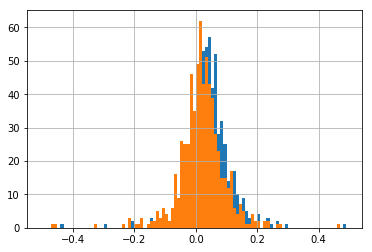

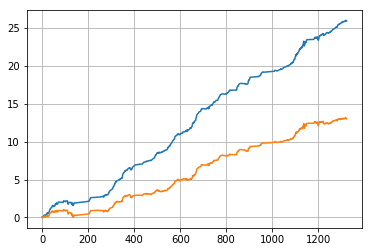

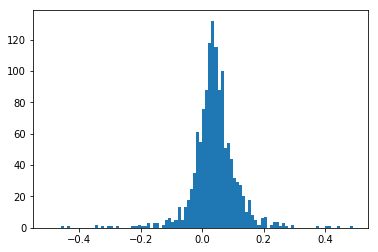

In [240]:
import matplotlib.pyplot as plt

plt.figure(0)
bins = [i/100 for i in range(-50,50)]
histG = plt.hist(positions[pos_under_2p]['GROI'], bins=bins)
histR = plt.hist(positions[pos_under_2p]['ROI'], bins=bins)
plt.grid()

plt.figure(1)
plt.plot(positions[pos_under_2p]['GROI'].cumsum())
plt.plot(positions[pos_under_2p]['ROI'].cumsum())
plt.grid()

plt.figure(2)
bins = [i/100 for i in range(-50,50)]
histG = plt.hist(positions['GROI'], bins=bins)

Di
11    0.0966
12   -0.6260
13    0.9499
14    0.1625
15   -0.0392
16    0.2588
17    0.2939
18    0.0387
19   -0.1764
20    0.8787
21   -0.0821
22    0.2667
23    1.4174
24   -0.2476
25    1.8157
26    1.3391
27    1.0509
28    0.8693
31    0.1168
32    0.1507
33   -0.1127
34    0.1068
35   -0.1720
36   -0.0566
37    0.6838
38    0.0119
39    0.6861
40    0.2077
41    0.3633
42    0.9019
43    0.6263
44    0.2112
45    1.0367
Name: ROI, dtype: float64


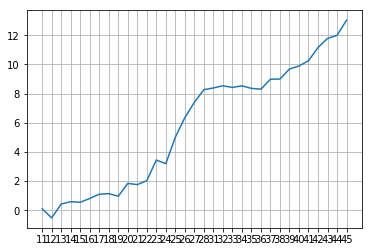

In [239]:
#positions
#grouped = pos_format.groupby(['asset'])
weekly_group = positions[pos_under_2p].groupby([pd.to_datetime(positions[pos_under_2p]['Di']).dt.strftime('%W')])['ROI']
weekly_sum = weekly_group.sum()
weekly_count = weekly_group.count()
#weekly_sum.cumsum()
plt.plot(weekly_sum.cumsum())
plt.grid()
print(weekly_sum)
#for name, group in groupedbyweek:
#    print(name)
#    print(group.to_string())
#pd.to_datetime(positions['Di']).dt.strftime('%W')
#pd.to_datetime(positions['Di'])#.groupby('Name').resample('W-Mon', on='Date').sum().reset_index().sort_values(by='Date')

In [212]:
positions[positions['ROI']<-.2]['ROI'].sum()

-5.5287999999999995

In [189]:
positions['GROI'].max()

0.7135